<a href="https://colab.research.google.com/github/pamelalee26/hatespeechdetection/blob/main/nb/Llama3_(8B)-Ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installation

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab and Kaggle notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.3: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.3.3 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep


In [81]:
import json
from collections import Counter
from datasets import DatasetDict, Dataset

# Load HateXplain dataset
with open("dataset.json", "r") as f:
    hatexplain_data = json.load(f)


# Load dataset splits (HateXplain provides predefined splits)
with open("post_id_divisions.json", "r") as f:
    dataset_splits = json.load(f)

# Extract train, validation, and test post IDs
train_ids = set(dataset_splits["train"])
val_ids = set(dataset_splits["val"])
test_ids = set(dataset_splits["test"])

def get_majority_label(annotations):
    """Extract the most common label among annotators."""
    labels = [ann["label"] for ann in annotations]
    most_common_label, _ = Counter(labels).most_common(1)[0]
    return most_common_label  # "hatespeech", "offensive", or "normal"

# Initialize train, validation, and test lists
train_samples = []
val_samples = []
test_samples = []

# Extract text and labels
for post_id, data in hatexplain_data.items():
    text_tokens = data["post_tokens"]  # Extract tokenized text
    text = " ".join(text_tokens)  # Convert tokens into a full sentence
    label = get_majority_label(data["annotators"])  # Get majority-voted label

    sample = {"text": text, "label": label}  # Store only text & label

    # Assign to appropriate split
    if post_id in train_ids:
        train_samples.append(sample)
    elif post_id in val_ids:
        val_samples.append(sample)
    elif post_id in test_ids:
        test_samples.append(sample)

# Convert lists to Hugging Face Dataset format
dataset = DatasetDict({
    "train": Dataset.from_list(train_samples),
    "validation": Dataset.from_list(val_samples),
    "test": Dataset.from_list(test_samples),
})

# Check dataset structure
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 15383
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1922
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1924
    })
})


In [82]:
print(dataset["train"][0].keys())  # Should show {'text': ..., 'label': ...}

dict_keys(['text', 'label'])


One issue is this dataset has multiple columns. For `Ollama` and `llama.cpp` to function like a custom `ChatGPT` Chatbot, we must only have 2 columns - an `instruction` and an `output` column.

To solve this, we shall do the following:
* Merge all columns into 1 instruction prompt.
* Remember LLMs are text predictors, so we can customize the instruction to anything we like!
* Use the `to_sharegpt` function to do this column merging process!

For example below in our [Titanic CSV finetuning notebook](https://colab.research.google.com/drive/1VYkncZMfGFkeCEgN2IzbZIKEDkyQuJAS?usp=sharing), we merged multiple columns in 1 prompt:

<img src="https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Merge.png" height="100">

To merge multiple columns into 1, use `merged_prompt`.
* Enclose all columns in curly braces `{}`.
* Optional text must be enclused in `[[]]`. For example if the column "Pclass" is empty, the merging function will not show the text and skp this. This is useful for datasets with missing values.
* You can select every column, or a few!
* Select the output or target / prediction column in `output_column_name`. For the Alpaca dataset, this will be `output`.

To make the finetune handle multiple turns (like in ChatGPT), we have to create a "fake" dataset with multiple turns - we use `conversation_extension` to randomnly select some conversations from the dataset, and pack them together into 1 conversation.

In [83]:
# Define the classification instruction
INSTRUCTION = (
    "You are a hate speech detection model. Your task is to classify text into one of three categories:"
    "1. Hate Speech – Content that directly or indirectly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes. This includes coded language, dog whistles, or implicit bias."
    "2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks."
    "3️. Normal – Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'."
    "Example 1:"
    "Text: 'All immigrants are criminals and should be kicked out of our country.'"
    "Classification: Hate Speech"
    "Example 2:"
    "Text: 'You're an absolute idiot, stop talking.'"
    "Classification:** Offensive"
    "Example 3:**"
    "Text:** 'A news report mentioned that a racist slur was used during the debate.'"
    "Classification: Normal"
    "Now, classify the following text, and Return ONLY one of these three words: 'Hate Speech', 'Offensive', or 'Normal'."
    "The text is:"
)

# Add "instruction" and rename "text" → "input"
for split in ["train", "validation", "test"]:
    dataset[split] = dataset[split].map(lambda x: {"instruction": INSTRUCTION, "input": x["text"]})

Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [84]:
print(dataset["train"][0])
print(dataset["train"][0].keys())  # Should show {'text': ..., 'label': ...}

{'text': 'we cannot continue calling ourselves feminists if the rights of all womxn arent addressed yes to a sexual offences public list but will a trans lesbian bisexual and queer womxn be able to enter their information on the reporting sheet gender forum', 'label': 'normal', 'instruction': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that directly or indirectly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes. This includes coded language, dog whistles, or implicit bias.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech wi

In [85]:
print(dataset["test"][20])

{'text': 'i hope the niglets keep going down on their knees its the only realistic depiction of blacks on fake news tv any chance of getting t shirts made that say <user> boycott nfl tebow rule cant pray owners are pleased with their blacks down on their knees', 'label': 'offensive', 'instruction': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that directly or indirectly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes. This includes coded language, dog whistles, or implicit bias.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language. If the text merely quotes hate spe

In [86]:
from unsloth import to_sharegpt

train_dataset = to_sharegpt(
    dataset["train"],
    merged_prompt="{instruction}[[\nYour input is:\n{input}]]",
    output_column_name="label"  # This contains the classification label
)

Merging columns:   0%|          | 0/15383 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/15383 [00:00<?, ? examples/s]

In [87]:
val_dataset = to_sharegpt(
    dataset["validation"],
    merged_prompt="{instruction}[[\nYour input is:\n{input}]]",
    output_column_name="label",  # This contains the classification label
)

test_dataset = to_sharegpt(
    dataset["test"],
    merged_prompt="{instruction}[[\nYour input is:\n{input}]]",
    output_column_name="label",  # This contains the classification label
)

Merging columns:   0%|          | 0/1922 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/1922 [00:00<?, ? examples/s]

Merging columns:   0%|          | 0/1924 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/1924 [00:00<?, ? examples/s]

Finally use `standardize_sharegpt` to fix up the dataset!

In [88]:
from unsloth import standardize_sharegpt

train_dataset = standardize_sharegpt(train_dataset)
val_dataset = standardize_sharegpt(val_dataset)
test_dataset = standardize_sharegpt(test_dataset)

Standardizing format:   0%|          | 0/15383 [00:00<?, ? examples/s]

Standardizing format:   0%|          | 0/1922 [00:00<?, ? examples/s]

Standardizing format:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [89]:
print(train_dataset)  # Should show {'text': ..., 'label': ...}
print(val_dataset)  # Should show {'text': ..., 'label': ...}
print(test_dataset)  # Should show {'text': ..., 'label': ...}

Dataset({
    features: ['conversations'],
    num_rows: 15383
})
Dataset({
    features: ['conversations'],
    num_rows: 1922
})
Dataset({
    features: ['conversations'],
    num_rows: 1924
})


### Customizable Chat Templates

You also need to specify a chat template. Previously, you could use the Alpaca format as shown below.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

Now, you have to use `{INPUT}` for the instruction and `{OUTPUT}` for the response.

We also allow you to use an optional `{SYSTEM}` field. This is useful for Ollama when you want to use a custom system prompt (also like in ChatGPT).

You can also not put a `{SYSTEM}` field, and just put plain text.

```python
chat_template = """{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""
```

Use below if you want to use the Llama-3 prompt format. You must use the `instruct` and not the `base` model if you use this!
```python
chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{OUTPUT}<|eot_id|>"""
```

For the ChatML format:
```python
chat_template = """<|im_start|>system
{SYSTEM}<|im_end|>
<|im_start|>user
{INPUT}<|im_end|>
<|im_start|>assistant
{OUTPUT}<|im_end|>"""
```

The issue is the Alpaca format has 3 fields, whilst OpenAI style chatbots must only use 2 fields (instruction and response). That's why we used the `to_sharegpt` function to merge these columns into 1.

In [90]:
chat_template = """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.

### Instruction:
{INPUT}

### Response:
{OUTPUT}"""

from unsloth import apply_chat_template

train_dataset = apply_chat_template(
    train_dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    # default_system_message = "You are a helpful assistant", << [OPTIONAL]
)

val_dataset = apply_chat_template(
    val_dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    # default_system_message = "You are a helpful assistant", << [OPTIONAL]
)

test_dataset = apply_chat_template(
    test_dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    # default_system_message = "You are a helpful assistant", << [OPTIONAL]
)

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/15383 [00:00<?, ? examples/s]

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/1922 [00:00<?, ? examples/s]

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/1924 [00:00<?, ? examples/s]

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [91]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        # num_train_epochs = 1, # For longer training runs!
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Converting train dataset to ChatML (num_proc=2):   0%|          | 0/15383 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=2):   0%|          | 0/15383 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=2):   0%|          | 0/15383 [00:00<?, ? examples/s]

Truncating train dataset (num_proc=2):   0%|          | 0/15383 [00:00<?, ? examples/s]

Converting eval dataset to ChatML (num_proc=2):   0%|          | 0/1922 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=2):   0%|          | 0/1922 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=2):   0%|          | 0/1922 [00:00<?, ? examples/s]

Truncating eval dataset (num_proc=2):   0%|          | 0/1922 [00:00<?, ? examples/s]

In [92]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.582 GB of memory reserved.


In [93]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 15,383 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/4,582,543,360 (0.92% trained)


Step,Training Loss
1,3.203600
2,3.245700
3,2.147500
4,1.650800
5,1.368900
6,1.203300
7,0.844400
8,0.741500
9,0.715000
10,0.484700


Step,Training Loss
1,3.203600
2,3.245700
3,2.147500
4,1.650800
5,1.368900
6,1.203300
7,0.844400
8,0.741500
9,0.715000
10,0.484700


In [94]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

525.8217 seconds used for training.
8.76 minutes used for training.
Peak reserved memory = 6.625 GB.
Peak reserved memory for training = 0.043 GB.
Peak reserved memory % of max memory = 44.943 %.
Peak reserved memory for training % of max memory = 0.292 %.


<a name="Inference"></a>
### Inference
Let's run the model! Unsloth makes inference natively 2x faster as well! You should use prompts which are similar to the ones you had finetuned on, otherwise you might get bad results!

In [96]:
print(test_dataset[0]["conversations"])

[{'content': "You are a hate speech detection model. Your task is to classify text into one of three categories:1. Hate Speech – Content that directly or indirectly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes. This includes coded language, dog whistles, or implicit bias.2️. Offensive – Content that contains insulting, rude, or hurtful language, but does not encourage violence or discrimination. This includes swearing, name-calling, and personal attacks.3️. Normal – Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language. If the text merely quotes hate speech without endorsing it, classify it as 'Normal'.Example 1:Text: 'All immigrants are criminals and should be kicked out of our country.'Classification: Hate SpeechExample 2:Text: 'You're an absolute idiot, stop talking.'Classification:** OffensiveExample 3:**Text:** 'A news report ment

In [97]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                    # Change below!
    {"role": "user", "content": "You are a hate speech detection model. "
    "Classify the given text into one of three categories: \n"
    "- 'Hate Speech': Content that directly promotes violence, discrimination, or hate against individuals or groups based on race, religion, gender, or other attributes.\n"
    "- 'Offensive': Content that is inappropriate, rude, or hurtful, where the speaker is using offensive language, but it does not promote violence or discrimination.\n"
    "- 'Normal': Content that is neutral, respectful, or reporting events, even if it contains references to hate speech or offensive language.\n"
    "Statements that merely **quote offensive or hate speech used by others, without intent to offend**, should be classified as 'Normal'.\n"
    "Return ONLY one of these three words: 'Hatespeech', 'Offensive', or 'Normal'. Do NOT provide any explanations or additional text."
    "Classify this text! Your input is 'i hope the niglets keep going down on their knees its the only realistic depiction of blacks on fake news tv any chance of getting t shirts made that say <user> boycott nfl tebow rule cant pray owners are pleased with their blacks down on their knees'"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

hatespeech<|end_of_text|>


In [ ]:
print(test_dataset["conversations"][0]["content"])

In [98]:
import torch
from transformers import TextStreamer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from tqdm import tqdm  # For progress tracking
from io import StringIO  # To capture streamed output

# Ensure model is in inference mode
FastLanguageModel.for_inference(model)

labels = ["Normal", "Offensive", "Hatespeech"]
labels_lower = [label.lower() for label in labels]  # Lowercase versions for matching

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset
for sample in tqdm(test_dataset):

    # Extract user message
    messages = [
        {"role": "user", "content": sample["conversations"][0]["content"]}
    ]

    # Tokenize input for LLaMA-3
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,  # Ensure model generates a response
        return_tensors="pt"
    ).to("cuda")

    # Create a buffer to capture streamed text
    output_buffer = StringIO()

    # Define a custom streamer that writes to the buffer
    class CaptureStreamer(TextStreamer):
        def __init__(self, tokenizer, stream):
            super().__init__(tokenizer, skip_prompt=True)
            self.stream = stream
        def on_finalized_text(self, text, stream_end=False):
            self.stream.write(text)

    # Use the custom streamer to capture output
    text_streamer = CaptureStreamer(tokenizer, output_buffer)

    # Generate prediction using streaming
    _ = model.generate(
        input_ids,
        streamer=text_streamer,  # Use the custom streamer
        max_new_tokens=5,  # Should be short (only one word)
        pad_token_id=tokenizer.eos_token_id
    )

    # Get the generated text from the buffer
    predicted_text = output_buffer.getvalue().strip()  # Extract text from buffer
    output_buffer.close()  # Close buffer to free memory

    # Remove "<|end_of_text|>" and clean text
    predicted_text = predicted_text.replace("<|end_of_text|>", "").strip()

    # Extract only the first word and normalize case
    predicted_label = predicted_text.split()[0].lower() if predicted_text else "unknown"

    # Validate the predicted label against allowed labels
    if predicted_label not in labels_lower:
        predicted_label = "unknown"

    # Store the results
    true_labels.append(sample["conversations"][1]["content"].lower())  # Ground truth
    predicted_labels.append(predicted_label)  # Model prediction

    # Print properly
    print(f"Predicted: {predicted_label} | Raw Output: {predicted_text}")

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute accuracy and F1 score (macro)
accuracy = accuracy_score(true_labels, predicted_labels)
f1_macro = f1_score(true_labels, predicted_labels, average="macro")

# Print results
print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")


  0%|          | 1/1924 [00:00<16:58,  1.89it/s]

Predicted: normal | Raw Output: normal


  0%|          | 2/1924 [00:01<19:08,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


  0%|          | 3/1924 [00:01<17:48,  1.80it/s]

Predicted: normal | Raw Output: normal


  0%|          | 4/1924 [00:02<19:08,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


  0%|          | 5/1924 [00:02<17:55,  1.78it/s]

Predicted: normal | Raw Output: normal


  0%|          | 6/1924 [00:03<17:45,  1.80it/s]

Predicted: normal | Raw Output: normal


  0%|          | 7/1924 [00:03<17:03,  1.87it/s]

Predicted: normal | Raw Output: normal


  0%|          | 8/1924 [00:04<18:23,  1.74it/s]

Predicted: hatespeech | Raw Output: hatespeech


  0%|          | 9/1924 [00:05<18:50,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 10/1924 [00:05<18:20,  1.74it/s]

Predicted: normal | Raw Output: normal


  1%|          | 11/1924 [00:06<19:00,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 12/1924 [00:06<18:17,  1.74it/s]

Predicted: normal | Raw Output: normal


  1%|          | 13/1924 [00:07<17:47,  1.79it/s]

Predicted: normal | Raw Output: normal


  1%|          | 14/1924 [00:08<18:40,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 15/1924 [00:08<18:00,  1.77it/s]

Predicted: normal | Raw Output: normal


  1%|          | 16/1924 [00:09<19:25,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 17/1924 [00:09<18:41,  1.70it/s]

Predicted: normal | Raw Output: normal


  1%|          | 18/1924 [00:10<18:34,  1.71it/s]

Predicted: normal | Raw Output: normal


  1%|          | 19/1924 [00:10<18:13,  1.74it/s]

Predicted: normal | Raw Output: normal


  1%|          | 20/1924 [00:11<19:21,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 21/1924 [00:12<19:37,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 22/1924 [00:12<20:02,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|          | 23/1924 [00:13<19:02,  1.66it/s]

Predicted: normal | Raw Output: normal


  1%|          | 24/1924 [00:14<18:28,  1.71it/s]

Predicted: normal | Raw Output: normal


  1%|▏         | 25/1924 [00:14<19:11,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|▏         | 26/1924 [00:15<19:34,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|▏         | 27/1924 [00:15<20:03,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  1%|▏         | 28/1924 [00:16<19:10,  1.65it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 29/1924 [00:17<19:42,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 30/1924 [00:17<19:58,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 31/1924 [00:18<19:10,  1.65it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 32/1924 [00:19<19:42,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 33/1924 [00:19<18:51,  1.67it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 34/1924 [00:20<19:32,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 35/1924 [00:20<18:47,  1.68it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 36/1924 [00:21<18:32,  1.70it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 37/1924 [00:22<18:58,  1.66it/s]

Predicted: offensive | Raw Output: offensive


  2%|▏         | 38/1924 [00:22<19:28,  1.61it/s]

Predicted: offensive | Raw Output: offensive


  2%|▏         | 39/1924 [00:23<18:57,  1.66it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 40/1924 [00:23<19:13,  1.63it/s]

Predicted: offensive | Raw Output: offensive


  2%|▏         | 41/1924 [00:24<18:31,  1.69it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 42/1924 [00:24<18:19,  1.71it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 43/1924 [00:25<17:57,  1.75it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 44/1924 [00:26<19:03,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 45/1924 [00:26<18:33,  1.69it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 46/1924 [00:27<18:12,  1.72it/s]

Predicted: normal | Raw Output: normal


  2%|▏         | 47/1924 [00:28<19:01,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  2%|▏         | 48/1924 [00:28<18:30,  1.69it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 49/1924 [00:29<18:21,  1.70it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 50/1924 [00:29<19:06,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 51/1924 [00:30<19:49,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 52/1924 [00:31<19:41,  1.58it/s]

Predicted: offensive | Raw Output: offensive


  3%|▎         | 53/1924 [00:31<20:08,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 54/1924 [00:32<19:22,  1.61it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 55/1924 [00:33<19:59,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 56/1924 [00:33<19:29,  1.60it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 57/1924 [00:34<19:02,  1.63it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 58/1924 [00:34<18:45,  1.66it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 59/1924 [00:35<20:01,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 60/1924 [00:36<20:26,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 61/1924 [00:36<19:33,  1.59it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 62/1924 [00:37<19:34,  1.58it/s]

Predicted: offensive | Raw Output: offensive


  3%|▎         | 63/1924 [00:37<18:40,  1.66it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 64/1924 [00:38<19:31,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 65/1924 [00:39<18:42,  1.66it/s]

Predicted: normal | Raw Output: normal


  3%|▎         | 66/1924 [00:39<19:34,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  3%|▎         | 67/1924 [00:40<19:02,  1.62it/s]

Predicted: normal | Raw Output: normal


  4%|▎         | 68/1924 [00:41<18:20,  1.69it/s]

Predicted: normal | Raw Output: normal


  4%|▎         | 69/1924 [00:41<19:14,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▎         | 70/1924 [00:42<18:25,  1.68it/s]

Predicted: normal | Raw Output: normal


  4%|▎         | 71/1924 [00:42<19:16,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▎         | 72/1924 [00:43<19:40,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 73/1924 [00:44<20:02,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 74/1924 [00:44<20:23,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 75/1924 [00:45<19:36,  1.57it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 76/1924 [00:46<18:53,  1.63it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 77/1924 [00:46<20:04,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 78/1924 [00:47<19:24,  1.59it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 79/1924 [00:48<19:57,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 80/1924 [00:48<19:00,  1.62it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 81/1924 [00:49<19:27,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 82/1924 [00:49<19:45,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 83/1924 [00:50<19:58,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


  4%|▍         | 84/1924 [00:51<19:01,  1.61it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 85/1924 [00:51<18:20,  1.67it/s]

Predicted: normal | Raw Output: normal


  4%|▍         | 86/1924 [00:52<19:02,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 87/1924 [00:53<19:13,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 88/1924 [00:53<19:36,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 89/1924 [00:54<18:40,  1.64it/s]

Predicted: normal | Raw Output: normal


  5%|▍         | 90/1924 [00:54<18:39,  1.64it/s]

Predicted: offensive | Raw Output: offensive


  5%|▍         | 91/1924 [00:55<18:29,  1.65it/s]

Predicted: offensive | Raw Output: offensive


  5%|▍         | 92/1924 [00:56<19:00,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 93/1924 [00:56<19:29,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 94/1924 [00:57<19:02,  1.60it/s]

Predicted: offensive | Raw Output: offensive


  5%|▍         | 95/1924 [00:58<20:12,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▍         | 96/1924 [00:58<19:05,  1.60it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 97/1924 [00:59<18:42,  1.63it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 98/1924 [01:00<19:37,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▌         | 99/1924 [01:00<18:51,  1.61it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 100/1924 [01:01<18:24,  1.65it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 101/1924 [01:01<17:54,  1.70it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 102/1924 [01:02<17:43,  1.71it/s]

Predicted: normal | Raw Output: normal


  5%|▌         | 103/1924 [01:02<18:20,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▌         | 104/1924 [01:03<18:50,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  5%|▌         | 105/1924 [01:04<19:12,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 106/1924 [01:04<19:22,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 107/1924 [01:05<19:34,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 108/1924 [01:06<19:48,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 109/1924 [01:06<18:40,  1.62it/s]

Predicted: normal | Raw Output: normal


  6%|▌         | 110/1924 [01:07<18:59,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 111/1924 [01:07<17:57,  1.68it/s]

Predicted: normal | Raw Output: normal


  6%|▌         | 112/1924 [01:08<18:36,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 113/1924 [01:09<18:55,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 114/1924 [01:09<18:34,  1.62it/s]

Predicted: offensive | Raw Output: offensive


  6%|▌         | 115/1924 [01:10<19:40,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 116/1924 [01:11<20:04,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 117/1924 [01:12<20:51,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▌         | 118/1924 [01:12<19:19,  1.56it/s]

Predicted: normal | Raw Output: normal


  6%|▌         | 119/1924 [01:13<18:21,  1.64it/s]

Predicted: normal | Raw Output: normal


  6%|▌         | 120/1924 [01:13<18:33,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▋         | 121/1924 [01:14<19:01,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▋         | 122/1924 [01:14<18:02,  1.66it/s]

Predicted: normal | Raw Output: normal


  6%|▋         | 123/1924 [01:15<18:38,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  6%|▋         | 124/1924 [01:16<17:36,  1.70it/s]

Predicted: normal | Raw Output: normal


  6%|▋         | 125/1924 [01:16<18:18,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 126/1924 [01:17<18:28,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 127/1924 [01:18<18:45,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 128/1924 [01:18<17:51,  1.68it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 129/1924 [01:19<17:09,  1.74it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 130/1924 [01:19<16:39,  1.80it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 131/1924 [01:20<16:19,  1.83it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 132/1924 [01:20<17:14,  1.73it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 133/1924 [01:21<17:50,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 134/1924 [01:22<18:18,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 135/1924 [01:22<19:26,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 136/1924 [01:23<18:19,  1.63it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 137/1924 [01:23<18:00,  1.65it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 138/1924 [01:24<17:28,  1.70it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 139/1924 [01:25<18:11,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 140/1924 [01:25<18:32,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 141/1924 [01:26<17:42,  1.68it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 142/1924 [01:26<17:02,  1.74it/s]

Predicted: normal | Raw Output: normal


  7%|▋         | 143/1924 [01:27<17:42,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


  7%|▋         | 144/1924 [01:28<17:59,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 145/1924 [01:28<17:49,  1.66it/s]

Predicted: offensive | Raw Output: offensive


  8%|▊         | 146/1924 [01:29<17:06,  1.73it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 147/1924 [01:29<17:51,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 148/1924 [01:30<18:14,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 149/1924 [01:31<17:27,  1.69it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 150/1924 [01:31<17:55,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 151/1924 [01:32<18:11,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 152/1924 [01:33<18:31,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 153/1924 [01:33<17:40,  1.67it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 154/1924 [01:34<17:32,  1.68it/s]

Predicted: offensive | Raw Output: offensive


  8%|▊         | 155/1924 [01:34<18:47,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 156/1924 [01:35<17:54,  1.65it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 157/1924 [01:36<19:19,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 158/1924 [01:36<18:22,  1.60it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 159/1924 [01:37<17:41,  1.66it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 160/1924 [01:37<16:57,  1.73it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 161/1924 [01:38<16:35,  1.77it/s]

Predicted: normal | Raw Output: normal


  8%|▊         | 162/1924 [01:38<17:17,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


  8%|▊         | 163/1924 [01:39<16:42,  1.76it/s]

Predicted: normal | Raw Output: normal


  9%|▊         | 164/1924 [01:40<16:22,  1.79it/s]

Predicted: normal | Raw Output: normal


  9%|▊         | 165/1924 [01:40<16:05,  1.82it/s]

Predicted: normal | Raw Output: normal


  9%|▊         | 166/1924 [01:41<15:57,  1.84it/s]

Predicted: normal | Raw Output: normal


  9%|▊         | 167/1924 [01:41<15:49,  1.85it/s]

Predicted: normal | Raw Output: normal


  9%|▊         | 168/1924 [01:42<15:54,  1.84it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 169/1924 [01:42<15:39,  1.87it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 170/1924 [01:43<15:45,  1.86it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 171/1924 [01:43<16:41,  1.75it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 172/1924 [01:44<17:35,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 173/1924 [01:45<17:00,  1.72it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 174/1924 [01:45<17:42,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 175/1924 [01:46<18:08,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 176/1924 [01:47<18:29,  1.58it/s]

Predicted: offensive | Raw Output: offensive


  9%|▉         | 177/1924 [01:47<17:52,  1.63it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 178/1924 [01:48<19:17,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 179/1924 [01:48<18:16,  1.59it/s]

Predicted: normal | Raw Output: normal


  9%|▉         | 180/1924 [01:49<18:41,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 181/1924 [01:50<18:46,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


  9%|▉         | 182/1924 [01:50<18:48,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|▉         | 183/1924 [01:51<18:58,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|▉         | 184/1924 [01:52<17:51,  1.62it/s]

Predicted: normal | Raw Output: normal


 10%|▉         | 185/1924 [01:52<17:14,  1.68it/s]

Predicted: normal | Raw Output: normal


 10%|▉         | 186/1924 [01:53<16:36,  1.74it/s]

Predicted: normal | Raw Output: normal


 10%|▉         | 187/1924 [01:53<16:20,  1.77it/s]

Predicted: normal | Raw Output: normal


 10%|▉         | 188/1924 [01:54<17:09,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|▉         | 189/1924 [01:55<17:42,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|▉         | 190/1924 [01:55<18:04,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|▉         | 191/1924 [01:56<17:49,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 10%|▉         | 192/1924 [01:56<18:08,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 193/1924 [01:57<18:27,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 194/1924 [01:58<18:38,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 195/1924 [01:59<19:02,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 196/1924 [01:59<19:44,  1.46it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 197/1924 [02:00<18:43,  1.54it/s]

Predicted: normal | Raw Output: normal


 10%|█         | 198/1924 [02:01<19:58,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 10%|█         | 199/1924 [02:01<18:39,  1.54it/s]

Predicted: normal | Raw Output: normal


 10%|█         | 200/1924 [02:02<17:53,  1.61it/s]

Predicted: normal | Raw Output: normal


 10%|█         | 201/1924 [02:02<17:04,  1.68it/s]

Predicted: normal | Raw Output: normal


 10%|█         | 202/1924 [02:03<16:37,  1.73it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 203/1924 [02:03<16:17,  1.76it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 204/1924 [02:04<16:08,  1.78it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 205/1924 [02:04<15:56,  1.80it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 206/1924 [02:05<16:51,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█         | 207/1924 [02:06<16:21,  1.75it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 208/1924 [02:06<16:40,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 11%|█         | 209/1924 [02:07<16:11,  1.77it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 210/1924 [02:07<16:04,  1.78it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 211/1924 [02:08<16:48,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█         | 212/1924 [02:09<17:32,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█         | 213/1924 [02:09<16:53,  1.69it/s]

Predicted: normal | Raw Output: normal


 11%|█         | 214/1924 [02:10<17:35,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█         | 215/1924 [02:11<18:19,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█         | 216/1924 [02:11<17:32,  1.62it/s]

Predicted: normal | Raw Output: normal


 11%|█▏        | 217/1924 [02:12<18:19,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 11%|█▏        | 218/1924 [02:12<17:38,  1.61it/s]

Predicted: normal | Raw Output: normal


 11%|█▏        | 219/1924 [02:13<17:40,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 11%|█▏        | 220/1924 [02:14<17:29,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 11%|█▏        | 221/1924 [02:14<16:54,  1.68it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 222/1924 [02:15<17:31,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 223/1924 [02:15<17:21,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 12%|█▏        | 224/1924 [02:16<17:49,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 225/1924 [02:17<18:08,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 226/1924 [02:17<18:18,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 227/1924 [02:18<18:31,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 228/1924 [02:19<17:30,  1.61it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 229/1924 [02:19<16:50,  1.68it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 230/1924 [02:20<16:13,  1.74it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 231/1924 [02:20<15:54,  1.77it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 232/1924 [02:21<16:45,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 233/1924 [02:22<16:41,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 12%|█▏        | 234/1924 [02:22<16:17,  1.73it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 235/1924 [02:23<16:23,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 12%|█▏        | 236/1924 [02:23<17:44,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 237/1924 [02:24<18:32,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 12%|█▏        | 238/1924 [02:25<17:47,  1.58it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 239/1924 [02:25<17:09,  1.64it/s]

Predicted: normal | Raw Output: normal


 12%|█▏        | 240/1924 [02:26<16:24,  1.71it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 241/1924 [02:26<15:59,  1.75it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 242/1924 [02:27<16:44,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 243/1924 [02:28<17:09,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 244/1924 [02:28<17:36,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 245/1924 [02:29<17:51,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 246/1924 [02:30<17:27,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 13%|█▎        | 247/1924 [02:30<16:42,  1.67it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 248/1924 [02:31<16:02,  1.74it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 249/1924 [02:31<15:47,  1.77it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 250/1924 [02:32<15:58,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 13%|█▎        | 251/1924 [02:32<16:11,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 13%|█▎        | 252/1924 [02:33<15:42,  1.77it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 253/1924 [02:34<16:36,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 254/1924 [02:34<15:56,  1.75it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 255/1924 [02:35<16:12,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 13%|█▎        | 256/1924 [02:35<16:01,  1.73it/s]

Predicted: normal | Raw Output: normal


 13%|█▎        | 257/1924 [02:36<16:31,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 13%|█▎        | 258/1924 [02:37<17:40,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 13%|█▎        | 259/1924 [02:37<18:44,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▎        | 260/1924 [02:38<17:28,  1.59it/s]

Predicted: normal | Raw Output: normal


 14%|█▎        | 261/1924 [02:38<17:16,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 14%|█▎        | 262/1924 [02:39<16:25,  1.69it/s]

Predicted: normal | Raw Output: normal


 14%|█▎        | 263/1924 [02:40<16:31,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 14%|█▎        | 264/1924 [02:40<17:02,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▍        | 265/1924 [02:41<16:49,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 14%|█▍        | 266/1924 [02:42<17:17,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▍        | 267/1924 [02:42<16:27,  1.68it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 268/1924 [02:43<17:02,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▍        | 269/1924 [02:43<16:40,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 14%|█▍        | 270/1924 [02:44<17:12,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▍        | 271/1924 [02:44<16:26,  1.68it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 272/1924 [02:45<15:58,  1.72it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 273/1924 [02:46<16:39,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 14%|█▍        | 274/1924 [02:46<15:56,  1.72it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 275/1924 [02:47<16:05,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 14%|█▍        | 276/1924 [02:47<15:30,  1.77it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 277/1924 [02:48<15:36,  1.76it/s]

Predicted: normal | Raw Output: normal


 14%|█▍        | 278/1924 [02:49<16:35,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 279/1924 [02:49<17:57,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 280/1924 [02:50<17:00,  1.61it/s]

Predicted: normal | Raw Output: normal


 15%|█▍        | 281/1924 [02:51<17:25,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 282/1924 [02:51<16:29,  1.66it/s]

Predicted: normal | Raw Output: normal


 15%|█▍        | 283/1924 [02:52<15:56,  1.72it/s]

Predicted: normal | Raw Output: normal


 15%|█▍        | 284/1924 [02:52<15:27,  1.77it/s]

Predicted: normal | Raw Output: normal


 15%|█▍        | 285/1924 [02:53<16:13,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 286/1924 [02:53<16:37,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 287/1924 [02:54<17:04,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▍        | 288/1924 [02:55<16:16,  1.68it/s]

Predicted: normal | Raw Output: normal


 15%|█▌        | 289/1924 [02:55<16:44,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 290/1924 [02:56<16:00,  1.70it/s]

Predicted: normal | Raw Output: normal


 15%|█▌        | 291/1924 [02:56<16:30,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 292/1924 [02:57<16:43,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 293/1924 [02:58<17:08,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 294/1924 [02:58<17:17,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 295/1924 [02:59<17:22,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 296/1924 [03:00<17:28,  1.55it/s]

Predicted: offensive | Raw Output: offensive


 15%|█▌        | 297/1924 [03:00<17:59,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 15%|█▌        | 298/1924 [03:01<18:48,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 299/1924 [03:02<18:45,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 300/1924 [03:03<18:23,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 301/1924 [03:03<18:19,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 302/1924 [03:04<17:35,  1.54it/s]

Predicted: offensive | Raw Output: offensive


 16%|█▌        | 303/1924 [03:04<16:39,  1.62it/s]

Predicted: normal | Raw Output: normal


 16%|█▌        | 304/1924 [03:05<16:57,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 305/1924 [03:06<17:07,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 306/1924 [03:06<17:21,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 307/1924 [03:07<17:22,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 308/1924 [03:08<16:27,  1.64it/s]

Predicted: normal | Raw Output: normal


 16%|█▌        | 309/1924 [03:08<16:55,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▌        | 310/1924 [03:09<16:30,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 16%|█▌        | 311/1924 [03:09<16:27,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 16%|█▌        | 312/1924 [03:10<16:47,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 16%|█▋        | 313/1924 [03:11<16:02,  1.67it/s]

Predicted: normal | Raw Output: normal


 16%|█▋        | 314/1924 [03:11<15:37,  1.72it/s]

Predicted: normal | Raw Output: normal


 16%|█▋        | 315/1924 [03:12<15:11,  1.77it/s]

Predicted: normal | Raw Output: normal


 16%|█▋        | 316/1924 [03:12<15:11,  1.76it/s]

Predicted: normal | Raw Output: normal


 16%|█▋        | 317/1924 [03:13<16:17,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 318/1924 [03:14<17:24,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 319/1924 [03:14<17:32,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 320/1924 [03:15<17:36,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 321/1924 [03:16<16:39,  1.60it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 322/1924 [03:16<16:54,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 323/1924 [03:17<16:01,  1.66it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 324/1924 [03:17<16:32,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 325/1924 [03:18<16:45,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 326/1924 [03:19<17:00,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 327/1924 [03:19<17:15,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 328/1924 [03:20<17:23,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 329/1924 [03:21<16:29,  1.61it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 330/1924 [03:21<15:47,  1.68it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 331/1924 [03:22<15:21,  1.73it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 332/1924 [03:22<15:58,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 333/1924 [03:23<16:28,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 334/1924 [03:24<15:47,  1.68it/s]

Predicted: normal | Raw Output: normal


 17%|█▋        | 335/1924 [03:24<16:57,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 17%|█▋        | 336/1924 [03:25<17:27,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 337/1924 [03:26<18:19,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 338/1924 [03:26<18:09,  1.46it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 339/1924 [03:27<17:52,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 340/1924 [03:28<16:51,  1.57it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 341/1924 [03:28<16:54,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 342/1924 [03:29<16:05,  1.64it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 343/1924 [03:29<15:29,  1.70it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 344/1924 [03:30<15:07,  1.74it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 345/1924 [03:30<14:46,  1.78it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 346/1924 [03:31<14:37,  1.80it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 347/1924 [03:32<15:25,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 348/1924 [03:32<15:58,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 349/1924 [03:33<15:26,  1.70it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 350/1924 [03:33<15:03,  1.74it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 351/1924 [03:34<15:20,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 18%|█▊        | 352/1924 [03:35<15:59,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 353/1924 [03:35<16:16,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 18%|█▊        | 354/1924 [03:36<15:37,  1.67it/s]

Predicted: normal | Raw Output: normal


 18%|█▊        | 355/1924 [03:37<16:48,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▊        | 356/1924 [03:37<17:15,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▊        | 357/1924 [03:38<18:05,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▊        | 358/1924 [03:39<17:23,  1.50it/s]

Predicted: offensive | Raw Output: offensive


 19%|█▊        | 359/1924 [03:39<17:25,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▊        | 360/1924 [03:40<17:17,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 361/1924 [03:41<17:12,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 362/1924 [03:41<16:18,  1.60it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 363/1924 [03:42<15:34,  1.67it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 364/1924 [03:42<15:01,  1.73it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 365/1924 [03:43<14:41,  1.77it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 366/1924 [03:43<15:23,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 367/1924 [03:44<14:53,  1.74it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 368/1924 [03:44<14:35,  1.78it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 369/1924 [03:45<14:55,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 19%|█▉        | 370/1924 [03:46<14:40,  1.77it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 371/1924 [03:46<15:24,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 372/1924 [03:47<14:55,  1.73it/s]

Predicted: normal | Raw Output: normal


 19%|█▉        | 373/1924 [03:47<15:39,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 374/1924 [03:48<15:57,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 19%|█▉        | 375/1924 [03:49<16:55,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 376/1924 [03:50<17:21,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 377/1924 [03:50<17:58,  1.43it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 378/1924 [03:51<16:44,  1.54it/s]

Predicted: normal | Raw Output: normal


 20%|█▉        | 379/1924 [03:52<16:58,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 380/1924 [03:52<16:54,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 381/1924 [03:53<16:56,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 382/1924 [03:54<17:01,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|█▉        | 383/1924 [03:54<16:01,  1.60it/s]

Predicted: normal | Raw Output: normal


 20%|█▉        | 384/1924 [03:55<16:14,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 385/1924 [03:55<16:26,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 386/1924 [03:56<15:36,  1.64it/s]

Predicted: normal | Raw Output: normal


 20%|██        | 387/1924 [03:56<15:02,  1.70it/s]

Predicted: normal | Raw Output: normal


 20%|██        | 388/1924 [03:57<15:05,  1.70it/s]

Predicted: offensive | Raw Output: offensive


 20%|██        | 389/1924 [03:58<15:39,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 390/1924 [03:58<15:55,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 391/1924 [03:59<16:14,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 392/1924 [04:00<15:32,  1.64it/s]

Predicted: normal | Raw Output: normal


 20%|██        | 393/1924 [04:00<15:55,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 20%|██        | 394/1924 [04:01<15:24,  1.65it/s]

Predicted: normal | Raw Output: normal


 21%|██        | 395/1924 [04:01<15:01,  1.70it/s]

Predicted: normal | Raw Output: normal


 21%|██        | 396/1924 [04:02<16:10,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 397/1924 [04:03<15:40,  1.62it/s]

Predicted: normal | Raw Output: normal


 21%|██        | 398/1924 [04:03<15:17,  1.66it/s]

Predicted: normal | Raw Output: normal


 21%|██        | 399/1924 [04:04<15:40,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 400/1924 [04:05<15:54,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 401/1924 [04:05<16:06,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 402/1924 [04:06<16:19,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 403/1924 [04:07<16:23,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 404/1924 [04:07<16:26,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 405/1924 [04:08<16:33,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 406/1924 [04:08<16:30,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██        | 407/1924 [04:09<15:36,  1.62it/s]

Predicted: normal | Raw Output: normal


 21%|██        | 408/1924 [04:10<15:22,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 21%|██▏       | 409/1924 [04:10<14:47,  1.71it/s]

Predicted: normal | Raw Output: normal


 21%|██▏       | 410/1924 [04:11<15:22,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██▏       | 411/1924 [04:11<15:07,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 21%|██▏       | 412/1924 [04:12<15:40,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 21%|██▏       | 413/1924 [04:13<15:55,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 414/1924 [04:13<15:24,  1.63it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 415/1924 [04:14<16:10,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 416/1924 [04:15<16:50,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 417/1924 [04:15<16:20,  1.54it/s]

Predicted: offensive | Raw Output: offensive


 22%|██▏       | 418/1924 [04:16<15:34,  1.61it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 419/1924 [04:17<15:39,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 420/1924 [04:17<15:59,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 421/1924 [04:18<16:04,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 422/1924 [04:19<16:15,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 423/1924 [04:19<16:17,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 424/1924 [04:20<15:24,  1.62it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 425/1924 [04:20<15:19,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 22%|██▏       | 426/1924 [04:21<14:35,  1.71it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 427/1924 [04:22<15:16,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 428/1924 [04:22<14:34,  1.71it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 429/1924 [04:23<15:14,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 430/1924 [04:23<15:37,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 22%|██▏       | 431/1924 [04:24<14:51,  1.67it/s]

Predicted: normal | Raw Output: normal


 22%|██▏       | 432/1924 [04:25<15:18,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 433/1924 [04:25<14:35,  1.70it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 434/1924 [04:26<14:24,  1.72it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 435/1924 [04:26<14:07,  1.76it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 436/1924 [04:27<15:33,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 437/1924 [04:27<14:47,  1.67it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 438/1924 [04:28<14:30,  1.71it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 439/1924 [04:29<14:50,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 440/1924 [04:29<15:19,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 441/1924 [04:30<15:32,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 442/1924 [04:31<15:45,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 443/1924 [04:31<15:03,  1.64it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 444/1924 [04:32<14:54,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 23%|██▎       | 445/1924 [04:32<15:12,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 446/1924 [04:33<15:31,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 447/1924 [04:34<14:57,  1.65it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 448/1924 [04:34<14:23,  1.71it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 449/1924 [04:35<14:00,  1.75it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 450/1924 [04:35<13:43,  1.79it/s]

Predicted: normal | Raw Output: normal


 23%|██▎       | 451/1924 [04:36<14:26,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 23%|██▎       | 452/1924 [04:37<14:47,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▎       | 453/1924 [04:37<15:08,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▎       | 454/1924 [04:38<16:09,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▎       | 455/1924 [04:38<15:15,  1.60it/s]

Predicted: normal | Raw Output: normal


 24%|██▎       | 456/1924 [04:39<16:26,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 457/1924 [04:40<16:25,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 458/1924 [04:41<16:18,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 459/1924 [04:41<15:30,  1.58it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 460/1924 [04:42<15:36,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 461/1924 [04:42<14:48,  1.65it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 462/1924 [04:43<15:19,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 463/1924 [04:44<14:34,  1.67it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 464/1924 [04:44<14:40,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 24%|██▍       | 465/1924 [04:45<14:01,  1.73it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 466/1924 [04:45<14:42,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 24%|██▍       | 467/1924 [04:46<14:08,  1.72it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 468/1924 [04:46<13:55,  1.74it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 469/1924 [04:47<13:31,  1.79it/s]

Predicted: normal | Raw Output: normal


 24%|██▍       | 470/1924 [04:48<13:51,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 24%|██▍       | 471/1924 [04:48<13:35,  1.78it/s]

Predicted: normal | Raw Output: normal


 25%|██▍       | 472/1924 [04:49<13:26,  1.80it/s]

Predicted: normal | Raw Output: normal


 25%|██▍       | 473/1924 [04:49<14:07,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▍       | 474/1924 [04:50<15:19,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▍       | 475/1924 [04:51<15:45,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▍       | 476/1924 [04:51<15:04,  1.60it/s]

Predicted: normal | Raw Output: normal


 25%|██▍       | 477/1924 [04:52<14:40,  1.64it/s]

Predicted: normal | Raw Output: normal


 25%|██▍       | 478/1924 [04:52<14:54,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▍       | 479/1924 [04:53<15:08,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▍       | 480/1924 [04:54<14:58,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 25%|██▌       | 481/1924 [04:54<14:46,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 25%|██▌       | 482/1924 [04:55<14:38,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 25%|██▌       | 483/1924 [04:56<15:01,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 25%|██▌       | 484/1924 [04:56<14:17,  1.68it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 485/1924 [04:57<13:52,  1.73it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 486/1924 [04:57<13:30,  1.77it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 487/1924 [04:58<13:16,  1.80it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 488/1924 [04:58<13:06,  1.83it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 489/1924 [04:59<12:58,  1.84it/s]

Predicted: normal | Raw Output: normal


 25%|██▌       | 490/1924 [04:59<12:57,  1.84it/s]

Predicted: normal | Raw Output: normal


 26%|██▌       | 491/1924 [05:00<12:53,  1.85it/s]

Predicted: normal | Raw Output: normal


 26%|██▌       | 492/1924 [05:01<13:46,  1.73it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 493/1924 [05:01<14:18,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 494/1924 [05:02<14:18,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 26%|██▌       | 495/1924 [05:02<14:00,  1.70it/s]

Predicted: normal | Raw Output: normal


 26%|██▌       | 496/1924 [05:03<14:14,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 26%|██▌       | 497/1924 [05:04<15:20,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 498/1924 [05:04<14:33,  1.63it/s]

Predicted: normal | Raw Output: normal


 26%|██▌       | 499/1924 [05:05<15:02,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 500/1924 [05:06<14:44,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 26%|██▌       | 501/1924 [05:06<14:11,  1.67it/s]

Predicted: normal | Raw Output: normal


 26%|██▌       | 502/1924 [05:07<14:35,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 503/1924 [05:07<14:48,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 504/1924 [05:08<15:07,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▌       | 505/1924 [05:09<15:14,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▋       | 506/1924 [05:09<15:19,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▋       | 507/1924 [05:10<15:28,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▋       | 508/1924 [05:11<15:33,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 26%|██▋       | 509/1924 [05:11<14:49,  1.59it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 510/1924 [05:12<15:05,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 511/1924 [05:13<15:09,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 512/1924 [05:13<14:28,  1.63it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 513/1924 [05:14<14:46,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 514/1924 [05:15<15:29,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 515/1924 [05:15<15:47,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 516/1924 [05:16<16:27,  1.43it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 517/1924 [05:17<15:44,  1.49it/s]

Predicted: offensive | Raw Output: offensive


 27%|██▋       | 518/1924 [05:17<14:53,  1.57it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 519/1924 [05:18<14:55,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 520/1924 [05:18<14:11,  1.65it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 521/1924 [05:19<13:47,  1.70it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 522/1924 [05:19<13:22,  1.75it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 523/1924 [05:20<14:09,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 524/1924 [05:21<13:33,  1.72it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 525/1924 [05:21<14:08,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 526/1924 [05:22<14:22,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 27%|██▋       | 527/1924 [05:22<13:46,  1.69it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 528/1924 [05:23<13:30,  1.72it/s]

Predicted: normal | Raw Output: normal


 27%|██▋       | 529/1924 [05:24<13:55,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 530/1924 [05:24<14:24,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 531/1924 [05:25<13:48,  1.68it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 532/1924 [05:26<14:14,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 533/1924 [05:26<13:41,  1.69it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 534/1924 [05:27<13:34,  1.71it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 535/1924 [05:27<14:32,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 536/1924 [05:28<14:07,  1.64it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 537/1924 [05:29<14:00,  1.65it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 538/1924 [05:29<13:30,  1.71it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 539/1924 [05:30<13:46,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 28%|██▊       | 540/1924 [05:30<14:08,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 541/1924 [05:31<14:01,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 28%|██▊       | 542/1924 [05:31<13:31,  1.70it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 543/1924 [05:32<13:12,  1.74it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 544/1924 [05:33<13:41,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 545/1924 [05:33<13:15,  1.73it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 546/1924 [05:34<12:59,  1.77it/s]

Predicted: normal | Raw Output: normal


 28%|██▊       | 547/1924 [05:34<13:36,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 28%|██▊       | 548/1924 [05:35<13:15,  1.73it/s]

Predicted: normal | Raw Output: normal


 29%|██▊       | 549/1924 [05:36<13:13,  1.73it/s]

Predicted: normal | Raw Output: normal


 29%|██▊       | 550/1924 [05:36<13:34,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 29%|██▊       | 551/1924 [05:37<14:44,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▊       | 552/1924 [05:38<14:54,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▊       | 553/1924 [05:38<14:55,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 554/1924 [05:39<15:38,  1.46it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 555/1924 [05:40<15:48,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 556/1924 [05:40<14:59,  1.52it/s]

Predicted: normal | Raw Output: normal


 29%|██▉       | 557/1924 [05:41<15:20,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 558/1924 [05:42<14:18,  1.59it/s]

Predicted: normal | Raw Output: normal


 29%|██▉       | 559/1924 [05:42<14:43,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 560/1924 [05:43<13:54,  1.63it/s]

Predicted: normal | Raw Output: normal


 29%|██▉       | 561/1924 [05:43<13:55,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 29%|██▉       | 562/1924 [05:44<14:07,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 563/1924 [05:45<14:22,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 564/1924 [05:45<14:38,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 565/1924 [05:46<14:40,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 566/1924 [05:47<14:43,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 29%|██▉       | 567/1924 [05:47<13:58,  1.62it/s]

Predicted: normal | Raw Output: normal


 30%|██▉       | 568/1924 [05:48<13:26,  1.68it/s]

Predicted: normal | Raw Output: normal


 30%|██▉       | 569/1924 [05:48<13:01,  1.73it/s]

Predicted: normal | Raw Output: normal


 30%|██▉       | 570/1924 [05:49<13:42,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 30%|██▉       | 571/1924 [05:50<13:33,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 30%|██▉       | 572/1924 [05:50<13:39,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 30%|██▉       | 573/1924 [05:51<13:07,  1.71it/s]

Predicted: normal | Raw Output: normal


 30%|██▉       | 574/1924 [05:51<13:08,  1.71it/s]

Predicted: normal | Raw Output: normal


 30%|██▉       | 575/1924 [05:52<14:02,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 30%|██▉       | 576/1924 [05:53<14:54,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 30%|██▉       | 577/1924 [05:53<14:05,  1.59it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 578/1924 [05:54<13:30,  1.66it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 579/1924 [05:54<13:54,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 30%|███       | 580/1924 [05:55<13:22,  1.67it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 581/1924 [05:56<12:58,  1.73it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 582/1924 [05:56<13:29,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 30%|███       | 583/1924 [05:57<13:31,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 30%|███       | 584/1924 [05:57<13:09,  1.70it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 585/1924 [05:58<12:44,  1.75it/s]

Predicted: normal | Raw Output: normal


 30%|███       | 586/1924 [05:59<13:16,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 587/1924 [05:59<12:48,  1.74it/s]

Predicted: normal | Raw Output: normal


 31%|███       | 588/1924 [06:00<13:26,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 589/1924 [06:00<13:21,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 31%|███       | 590/1924 [06:01<13:45,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 591/1924 [06:02<13:15,  1.68it/s]

Predicted: normal | Raw Output: normal


 31%|███       | 592/1924 [06:02<13:43,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 593/1924 [06:03<13:57,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 594/1924 [06:04<14:08,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 31%|███       | 595/1924 [06:04<13:37,  1.63it/s]

Predicted: normal | Raw Output: normal


 31%|███       | 596/1924 [06:05<13:58,  1.58it/s]

Predicted: offensive | Raw Output: offensive


 31%|███       | 597/1924 [06:05<14:32,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 598/1924 [06:06<14:35,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███       | 599/1924 [06:07<13:51,  1.59it/s]

Predicted: normal | Raw Output: normal


 31%|███       | 600/1924 [06:07<13:09,  1.68it/s]

Predicted: normal | Raw Output: normal


 31%|███       | 601/1924 [06:08<12:45,  1.73it/s]

Predicted: normal | Raw Output: normal


 31%|███▏      | 602/1924 [06:08<12:24,  1.77it/s]

Predicted: normal | Raw Output: normal


 31%|███▏      | 603/1924 [06:09<13:03,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 31%|███▏      | 604/1924 [06:10<13:01,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 31%|███▏      | 605/1924 [06:10<13:04,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 31%|███▏      | 606/1924 [06:11<13:27,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 607/1924 [06:11<13:51,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 608/1924 [06:12<13:12,  1.66it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 609/1924 [06:13<13:37,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 610/1924 [06:13<13:00,  1.68it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 611/1924 [06:14<12:38,  1.73it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 612/1924 [06:14<12:16,  1.78it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 613/1924 [06:15<12:58,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 614/1924 [06:16<13:55,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 615/1924 [06:16<13:50,  1.58it/s]

Predicted: offensive | Raw Output: offensive


 32%|███▏      | 616/1924 [06:17<14:06,  1.54it/s]

Predicted: offensive | Raw Output: offensive


 32%|███▏      | 617/1924 [06:18<13:38,  1.60it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 618/1924 [06:18<13:08,  1.66it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 619/1924 [06:19<13:35,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 620/1924 [06:19<12:54,  1.68it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 621/1924 [06:20<12:41,  1.71it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 622/1924 [06:21<13:07,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 623/1924 [06:21<13:31,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 32%|███▏      | 624/1924 [06:22<12:56,  1.67it/s]

Predicted: normal | Raw Output: normal


 32%|███▏      | 625/1924 [06:22<12:33,  1.72it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 626/1924 [06:23<12:17,  1.76it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 627/1924 [06:23<12:04,  1.79it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 628/1924 [06:24<11:53,  1.82it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 629/1924 [06:24<11:50,  1.82it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 630/1924 [06:25<12:38,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 631/1924 [06:26<12:59,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 632/1924 [06:26<13:24,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 633/1924 [06:27<13:19,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 33%|███▎      | 634/1924 [06:28<13:31,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 635/1924 [06:28<14:06,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 636/1924 [06:29<14:39,  1.46it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 637/1924 [06:30<15:09,  1.41it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 638/1924 [06:31<14:58,  1.43it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 639/1924 [06:31<14:46,  1.45it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 640/1924 [06:32<13:48,  1.55it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 641/1924 [06:32<13:53,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 642/1924 [06:33<13:07,  1.63it/s]

Predicted: normal | Raw Output: normal


 33%|███▎      | 643/1924 [06:34<13:25,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 33%|███▎      | 644/1924 [06:34<13:14,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 34%|███▎      | 645/1924 [06:35<13:28,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▎      | 646/1924 [06:36<13:38,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▎      | 647/1924 [06:36<13:18,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 34%|███▎      | 648/1924 [06:37<12:43,  1.67it/s]

Predicted: normal | Raw Output: normal


 34%|███▎      | 649/1924 [06:37<12:15,  1.73it/s]

Predicted: normal | Raw Output: normal


 34%|███▍      | 650/1924 [06:38<12:48,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 651/1924 [06:38<12:16,  1.73it/s]

Predicted: normal | Raw Output: normal


 34%|███▍      | 652/1924 [06:39<12:55,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 653/1924 [06:40<12:44,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 34%|███▍      | 654/1924 [06:40<13:44,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 655/1924 [06:41<13:34,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 34%|███▍      | 656/1924 [06:42<13:13,  1.60it/s]

Predicted: normal | Raw Output: normal


 34%|███▍      | 657/1924 [06:42<13:27,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 34%|███▍      | 658/1924 [06:43<12:46,  1.65it/s]

Predicted: normal | Raw Output: normal


 34%|███▍      | 659/1924 [06:43<12:30,  1.69it/s]

Predicted: normal | Raw Output: normal


 34%|███▍      | 660/1924 [06:44<12:47,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 661/1924 [06:45<13:12,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 662/1924 [06:45<13:26,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 34%|███▍      | 663/1924 [06:46<12:44,  1.65it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 664/1924 [06:46<12:22,  1.70it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 665/1924 [06:47<12:46,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▍      | 666/1924 [06:48<12:17,  1.71it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 667/1924 [06:48<11:59,  1.75it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 668/1924 [06:49<12:29,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▍      | 669/1924 [06:49<12:51,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▍      | 670/1924 [06:50<12:23,  1.69it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 671/1924 [06:51<12:03,  1.73it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 672/1924 [06:51<11:47,  1.77it/s]

Predicted: normal | Raw Output: normal


 35%|███▍      | 673/1924 [06:52<11:38,  1.79it/s]

Predicted: normal | Raw Output: normal


 35%|███▌      | 674/1924 [06:52<12:10,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 675/1924 [06:53<12:28,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 35%|███▌      | 676/1924 [06:54<13:07,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 677/1924 [06:54<13:59,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 678/1924 [06:55<13:55,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 679/1924 [06:56<13:06,  1.58it/s]

Predicted: normal | Raw Output: normal


 35%|███▌      | 680/1924 [06:56<12:32,  1.65it/s]

Predicted: normal | Raw Output: normal


 35%|███▌      | 681/1924 [06:57<12:48,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 682/1924 [06:57<13:02,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 35%|███▌      | 683/1924 [06:58<12:25,  1.67it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 684/1924 [06:59<12:01,  1.72it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 685/1924 [06:59<11:40,  1.77it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 686/1924 [07:00<12:16,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 687/1924 [07:00<11:48,  1.75it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 688/1924 [07:01<12:22,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 689/1924 [07:02<12:41,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 690/1924 [07:02<12:56,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 691/1924 [07:03<12:25,  1.65it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 692/1924 [07:03<12:42,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 693/1924 [07:04<12:10,  1.68it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 694/1924 [07:04<11:47,  1.74it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 695/1924 [07:05<11:44,  1.74it/s]

Predicted: normal | Raw Output: normal


 36%|███▌      | 696/1924 [07:06<12:28,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▌      | 697/1924 [07:07<13:20,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▋      | 698/1924 [07:07<13:28,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▋      | 699/1924 [07:08<13:27,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▋      | 700/1924 [07:08<13:27,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▋      | 701/1924 [07:09<13:19,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 36%|███▋      | 702/1924 [07:10<12:41,  1.60it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 703/1924 [07:10<12:07,  1.68it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 704/1924 [07:11<12:34,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 705/1924 [07:12<12:44,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 706/1924 [07:12<12:13,  1.66it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 707/1924 [07:13<11:46,  1.72it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 708/1924 [07:13<11:28,  1.77it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 709/1924 [07:14<12:02,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 710/1924 [07:14<12:26,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 711/1924 [07:15<12:40,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 712/1924 [07:16<12:06,  1.67it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 713/1924 [07:16<12:03,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 37%|███▋      | 714/1924 [07:17<11:38,  1.73it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 715/1924 [07:17<12:01,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 37%|███▋      | 716/1924 [07:18<11:43,  1.72it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 717/1924 [07:19<12:58,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 718/1924 [07:19<13:00,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 719/1924 [07:20<12:21,  1.63it/s]

Predicted: normal | Raw Output: normal


 37%|███▋      | 720/1924 [07:21<12:42,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 37%|███▋      | 721/1924 [07:21<12:44,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 722/1924 [07:22<12:30,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 38%|███▊      | 723/1924 [07:22<11:56,  1.68it/s]

Predicted: normal | Raw Output: normal


 38%|███▊      | 724/1924 [07:23<12:19,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 725/1924 [07:24<12:31,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 726/1924 [07:24<12:18,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 38%|███▊      | 727/1924 [07:25<12:33,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 728/1924 [07:26<11:57,  1.67it/s]

Predicted: normal | Raw Output: normal


 38%|███▊      | 729/1924 [07:26<11:36,  1.72it/s]

Predicted: normal | Raw Output: normal


 38%|███▊      | 730/1924 [07:27<11:59,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 731/1924 [07:27<12:19,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 732/1924 [07:28<12:13,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 38%|███▊      | 733/1924 [07:29<12:05,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 38%|███▊      | 734/1924 [07:29<11:43,  1.69it/s]

Predicted: normal | Raw Output: normal


 38%|███▊      | 735/1924 [07:30<11:28,  1.73it/s]

Predicted: normal | Raw Output: normal


 38%|███▊      | 736/1924 [07:30<12:13,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 737/1924 [07:31<13:06,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 738/1924 [07:32<13:08,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 739/1924 [07:32<13:04,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 38%|███▊      | 740/1924 [07:33<12:23,  1.59it/s]

Predicted: normal | Raw Output: normal


 39%|███▊      | 741/1924 [07:34<12:29,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▊      | 742/1924 [07:34<12:36,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▊      | 743/1924 [07:35<12:20,  1.59it/s]

Predicted: offensive | Raw Output: offensive


 39%|███▊      | 744/1924 [07:36<12:33,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▊      | 745/1924 [07:36<12:38,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▉      | 746/1924 [07:37<12:00,  1.64it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 747/1924 [07:37<11:33,  1.70it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 748/1924 [07:38<11:12,  1.75it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 749/1924 [07:38<11:02,  1.77it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 750/1924 [07:39<11:32,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▉      | 751/1924 [07:40<11:10,  1.75it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 752/1924 [07:40<11:45,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▉      | 753/1924 [07:41<11:17,  1.73it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 754/1924 [07:41<11:05,  1.76it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 755/1924 [07:42<11:24,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 39%|███▉      | 756/1924 [07:43<11:43,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 39%|███▉      | 757/1924 [07:43<11:29,  1.69it/s]

Predicted: normal | Raw Output: normal


 39%|███▉      | 758/1924 [07:44<11:59,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 39%|███▉      | 759/1924 [07:44<11:32,  1.68it/s]

Predicted: normal | Raw Output: normal


 40%|███▉      | 760/1924 [07:45<11:59,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 761/1924 [07:46<12:09,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 762/1924 [07:46<12:20,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 763/1924 [07:47<11:48,  1.64it/s]

Predicted: normal | Raw Output: normal


 40%|███▉      | 764/1924 [07:47<11:43,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 40%|███▉      | 765/1924 [07:48<12:02,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 766/1924 [07:49<11:29,  1.68it/s]

Predicted: normal | Raw Output: normal


 40%|███▉      | 767/1924 [07:49<11:53,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 768/1924 [07:50<12:05,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|███▉      | 769/1924 [07:51<11:35,  1.66it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 770/1924 [07:51<11:56,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|████      | 771/1924 [07:52<11:20,  1.69it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 772/1924 [07:52<11:06,  1.73it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 773/1924 [07:53<10:46,  1.78it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 774/1924 [07:53<11:20,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 40%|████      | 775/1924 [07:54<11:36,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 40%|████      | 776/1924 [07:55<11:23,  1.68it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 777/1924 [07:55<11:19,  1.69it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 778/1924 [07:56<11:11,  1.71it/s]

Predicted: normal | Raw Output: normal


 40%|████      | 779/1924 [07:56<11:45,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████      | 780/1924 [07:57<11:56,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████      | 781/1924 [07:58<12:10,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████      | 782/1924 [07:58<11:36,  1.64it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 783/1924 [07:59<11:30,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 41%|████      | 784/1924 [07:59<11:03,  1.72it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 785/1924 [08:00<10:51,  1.75it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 786/1924 [08:01<10:37,  1.78it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 787/1924 [08:01<10:53,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 41%|████      | 788/1924 [08:02<10:34,  1.79it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 789/1924 [08:02<10:28,  1.81it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 790/1924 [08:03<10:19,  1.83it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 791/1924 [08:03<10:18,  1.83it/s]

Predicted: normal | Raw Output: normal


 41%|████      | 792/1924 [08:04<10:55,  1.73it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████      | 793/1924 [08:05<11:20,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████▏     | 794/1924 [08:05<11:17,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 41%|████▏     | 795/1924 [08:06<11:39,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 41%|████▏     | 796/1924 [08:06<11:13,  1.67it/s]

Predicted: normal | Raw Output: normal


 41%|████▏     | 797/1924 [08:07<11:03,  1.70it/s]

Predicted: normal | Raw Output: normal


 41%|████▏     | 798/1924 [08:08<11:56,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 799/1924 [08:08<12:03,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 800/1924 [08:09<11:31,  1.63it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 801/1924 [08:09<11:01,  1.70it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 802/1924 [08:10<10:47,  1.73it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 803/1924 [08:11<10:34,  1.77it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 804/1924 [08:11<11:06,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 805/1924 [08:12<10:42,  1.74it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 806/1924 [08:12<10:33,  1.77it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 807/1924 [08:13<10:19,  1.80it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 808/1924 [08:13<10:35,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 42%|████▏     | 809/1924 [08:14<10:22,  1.79it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 810/1924 [08:15<10:58,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 811/1924 [08:15<11:21,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 812/1924 [08:16<11:40,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 813/1924 [08:17<11:17,  1.64it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 814/1924 [08:17<11:32,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 815/1924 [08:18<11:00,  1.68it/s]

Predicted: normal | Raw Output: normal


 42%|████▏     | 816/1924 [08:18<12:01,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 42%|████▏     | 817/1924 [08:19<11:23,  1.62it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 818/1924 [08:20<11:16,  1.64it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 819/1924 [08:20<12:00,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 820/1924 [08:21<11:25,  1.61it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 821/1924 [08:22<11:22,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 43%|████▎     | 822/1924 [08:22<11:31,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 823/1924 [08:23<11:01,  1.66it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 824/1924 [08:23<10:39,  1.72it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 825/1924 [08:24<11:05,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 826/1924 [08:25<11:04,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 43%|████▎     | 827/1924 [08:25<10:41,  1.71it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 828/1924 [08:26<11:06,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 829/1924 [08:26<11:19,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 830/1924 [08:27<11:31,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 831/1924 [08:28<11:00,  1.65it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 832/1924 [08:28<11:17,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 833/1924 [08:29<10:47,  1.68it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 834/1924 [08:29<10:29,  1.73it/s]

Predicted: normal | Raw Output: normal


 43%|████▎     | 835/1924 [08:30<10:58,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 43%|████▎     | 836/1924 [08:31<10:33,  1.72it/s]

Predicted: normal | Raw Output: normal


 44%|████▎     | 837/1924 [08:31<11:18,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▎     | 838/1924 [08:32<10:55,  1.66it/s]

Predicted: normal | Raw Output: normal


 44%|████▎     | 839/1924 [08:32<11:18,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 44%|████▎     | 840/1924 [08:33<11:28,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▎     | 841/1924 [08:34<11:00,  1.64it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 842/1924 [08:34<11:13,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 843/1924 [08:35<10:47,  1.67it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 844/1924 [08:35<10:30,  1.71it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 845/1924 [08:36<10:55,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 846/1924 [08:37<11:11,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 847/1924 [08:37<11:25,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 848/1924 [08:38<11:36,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 849/1924 [08:39<11:02,  1.62it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 850/1924 [08:39<11:14,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 851/1924 [08:40<10:45,  1.66it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 852/1924 [08:40<11:05,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 853/1924 [08:41<10:36,  1.68it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 854/1924 [08:42<10:59,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 44%|████▍     | 855/1924 [08:42<10:29,  1.70it/s]

Predicted: normal | Raw Output: normal


 44%|████▍     | 856/1924 [08:43<10:14,  1.74it/s]

Predicted: normal | Raw Output: normal


 45%|████▍     | 857/1924 [08:43<10:02,  1.77it/s]

Predicted: normal | Raw Output: normal


 45%|████▍     | 858/1924 [08:44<10:50,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▍     | 859/1924 [08:45<11:04,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 45%|████▍     | 860/1924 [08:45<10:40,  1.66it/s]

Predicted: normal | Raw Output: normal


 45%|████▍     | 861/1924 [08:46<10:59,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▍     | 862/1924 [08:47<11:08,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▍     | 863/1924 [08:47<11:19,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▍     | 864/1924 [08:48<10:50,  1.63it/s]

Predicted: normal | Raw Output: normal


 45%|████▍     | 865/1924 [08:48<11:03,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▌     | 866/1924 [08:49<10:50,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 45%|████▌     | 867/1924 [08:50<10:43,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 45%|████▌     | 868/1924 [08:50<11:03,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▌     | 869/1924 [08:51<11:10,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▌     | 870/1924 [08:51<10:42,  1.64it/s]

Predicted: normal | Raw Output: normal


 45%|████▌     | 871/1924 [08:52<10:17,  1.71it/s]

Predicted: normal | Raw Output: normal


 45%|████▌     | 872/1924 [08:53<09:59,  1.75it/s]

Predicted: normal | Raw Output: normal


 45%|████▌     | 873/1924 [08:53<10:26,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 45%|████▌     | 874/1924 [08:54<10:05,  1.73it/s]

Predicted: normal | Raw Output: normal


 45%|████▌     | 875/1924 [08:54<10:34,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 876/1924 [08:55<10:09,  1.72it/s]

Predicted: normal | Raw Output: normal


 46%|████▌     | 877/1924 [08:56<10:59,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 878/1924 [08:56<10:27,  1.67it/s]

Predicted: normal | Raw Output: normal


 46%|████▌     | 879/1924 [08:57<11:24,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 880/1924 [08:57<10:46,  1.62it/s]

Predicted: normal | Raw Output: normal


 46%|████▌     | 881/1924 [08:58<10:48,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 46%|████▌     | 882/1924 [08:59<10:34,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 46%|████▌     | 883/1924 [08:59<10:53,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 884/1924 [09:00<11:02,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 885/1924 [09:01<11:08,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 886/1924 [09:01<10:37,  1.63it/s]

Predicted: normal | Raw Output: normal


 46%|████▌     | 887/1924 [09:02<10:15,  1.68it/s]

Predicted: normal | Raw Output: normal


 46%|████▌     | 888/1924 [09:02<10:34,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▌     | 889/1924 [09:03<10:07,  1.70it/s]

Predicted: normal | Raw Output: normal


 46%|████▋     | 890/1924 [09:04<10:11,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 46%|████▋     | 891/1924 [09:04<09:51,  1.75it/s]

Predicted: normal | Raw Output: normal


 46%|████▋     | 892/1924 [09:05<09:43,  1.77it/s]

Predicted: normal | Raw Output: normal


 46%|████▋     | 893/1924 [09:05<10:09,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 46%|████▋     | 894/1924 [09:06<09:51,  1.74it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 895/1924 [09:06<09:42,  1.77it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 896/1924 [09:07<09:31,  1.80it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 897/1924 [09:08<10:31,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 47%|████▋     | 898/1924 [09:08<10:34,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 47%|████▋     | 899/1924 [09:09<10:23,  1.64it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 900/1924 [09:09<10:11,  1.68it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 901/1924 [09:10<10:31,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 47%|████▋     | 902/1924 [09:11<10:21,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 47%|████▋     | 903/1924 [09:11<10:17,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 47%|████▋     | 904/1924 [09:12<09:58,  1.71it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 905/1924 [09:12<09:43,  1.75it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 906/1924 [09:13<10:11,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 47%|████▋     | 907/1924 [09:14<09:49,  1.72it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 908/1924 [09:14<09:39,  1.75it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 909/1924 [09:15<10:02,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 47%|████▋     | 910/1924 [09:15<09:44,  1.73it/s]

Predicted: normal | Raw Output: normal


 47%|████▋     | 911/1924 [09:16<09:49,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 47%|████▋     | 912/1924 [09:17<10:10,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 47%|████▋     | 913/1924 [09:17<10:27,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 914/1924 [09:18<10:38,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 915/1924 [09:18<10:08,  1.66it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 916/1924 [09:19<10:31,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 917/1924 [09:20<10:10,  1.65it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 918/1924 [09:20<10:45,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 919/1924 [09:21<11:21,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 920/1924 [09:22<10:50,  1.54it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 921/1924 [09:22<10:58,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 922/1924 [09:23<10:25,  1.60it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 923/1924 [09:24<10:34,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 924/1924 [09:24<10:06,  1.65it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 925/1924 [09:25<09:46,  1.70it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 926/1924 [09:25<09:28,  1.76it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 927/1924 [09:26<09:37,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 48%|████▊     | 928/1924 [09:26<09:41,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 48%|████▊     | 929/1924 [09:27<09:24,  1.76it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 930/1924 [09:28<09:35,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 48%|████▊     | 931/1924 [09:28<09:56,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 48%|████▊     | 932/1924 [09:29<09:38,  1.71it/s]

Predicted: normal | Raw Output: normal


 48%|████▊     | 933/1924 [09:29<09:23,  1.76it/s]

Predicted: normal | Raw Output: normal


 49%|████▊     | 934/1924 [09:30<09:29,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 49%|████▊     | 935/1924 [09:31<09:54,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▊     | 936/1924 [09:31<10:10,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▊     | 937/1924 [09:32<10:32,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 938/1924 [09:32<10:06,  1.63it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 939/1924 [09:33<09:48,  1.67it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 940/1924 [09:34<10:37,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 941/1924 [09:34<10:03,  1.63it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 942/1924 [09:35<10:23,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 943/1924 [09:35<09:50,  1.66it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 944/1924 [09:36<09:32,  1.71it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 945/1924 [09:37<09:50,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 946/1924 [09:37<09:27,  1.72it/s]

Predicted: normal | Raw Output: normal


 49%|████▉     | 947/1924 [09:38<09:49,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 948/1924 [09:39<10:01,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 949/1924 [09:39<10:12,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 950/1924 [09:40<10:22,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 951/1924 [09:40<10:24,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 49%|████▉     | 952/1924 [09:41<10:31,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 953/1924 [09:42<10:33,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 954/1924 [09:42<10:32,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 955/1924 [09:43<10:01,  1.61it/s]

Predicted: normal | Raw Output: normal


 50%|████▉     | 956/1924 [09:44<09:51,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 50%|████▉     | 957/1924 [09:44<10:29,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 958/1924 [09:45<10:40,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 959/1924 [09:46<10:12,  1.58it/s]

Predicted: normal | Raw Output: normal


 50%|████▉     | 960/1924 [09:46<10:32,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|████▉     | 961/1924 [09:47<10:33,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|█████     | 962/1924 [09:48<10:02,  1.60it/s]

Predicted: normal | Raw Output: normal


 50%|█████     | 963/1924 [09:48<10:14,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|█████     | 964/1924 [09:49<10:14,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|█████     | 965/1924 [09:49<09:46,  1.64it/s]

Predicted: normal | Raw Output: normal


 50%|█████     | 966/1924 [09:50<09:23,  1.70it/s]

Predicted: normal | Raw Output: normal


 50%|█████     | 967/1924 [09:51<09:25,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 50%|█████     | 968/1924 [09:51<09:26,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 50%|█████     | 969/1924 [09:52<09:41,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 50%|█████     | 970/1924 [09:52<09:18,  1.71it/s]

Predicted: normal | Raw Output: normal


 50%|█████     | 971/1924 [09:53<09:03,  1.75it/s]

Predicted: normal | Raw Output: normal


 51%|█████     | 972/1924 [09:53<09:09,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 51%|█████     | 973/1924 [09:54<08:55,  1.78it/s]

Predicted: normal | Raw Output: normal


 51%|█████     | 974/1924 [09:54<08:48,  1.80it/s]

Predicted: normal | Raw Output: normal


 51%|█████     | 975/1924 [09:55<09:16,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 976/1924 [09:56<09:36,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 977/1924 [09:57<10:15,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 978/1924 [09:57<10:36,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 979/1924 [09:58<10:56,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 980/1924 [09:59<10:13,  1.54it/s]

Predicted: normal | Raw Output: normal


 51%|█████     | 981/1924 [09:59<10:20,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 982/1924 [10:00<10:15,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 983/1924 [10:00<10:00,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 51%|█████     | 984/1924 [10:01<10:23,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 985/1924 [10:02<10:35,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████     | 986/1924 [10:03<11:03,  1.41it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████▏    | 987/1924 [10:03<10:16,  1.52it/s]

Predicted: normal | Raw Output: normal


 51%|█████▏    | 988/1924 [10:04<10:21,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████▏    | 989/1924 [10:05<10:18,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 51%|█████▏    | 990/1924 [10:05<09:57,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 52%|█████▏    | 991/1924 [10:06<10:04,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 992/1924 [10:06<09:29,  1.64it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 993/1924 [10:07<09:09,  1.69it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 994/1924 [10:07<08:51,  1.75it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 995/1924 [10:08<09:00,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 52%|█████▏    | 996/1924 [10:09<08:54,  1.74it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 997/1924 [10:09<08:48,  1.75it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 998/1924 [10:10<08:49,  1.75it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 999/1924 [10:10<08:48,  1.75it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 1000/1924 [10:11<09:15,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1001/1924 [10:11<08:55,  1.72it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 1002/1924 [10:12<09:16,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1003/1924 [10:13<08:54,  1.72it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 1004/1924 [10:13<09:16,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1005/1924 [10:14<09:12,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 52%|█████▏    | 1006/1924 [10:15<09:27,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1007/1924 [10:15<09:34,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1008/1924 [10:16<09:06,  1.68it/s]

Predicted: normal | Raw Output: normal


 52%|█████▏    | 1009/1924 [10:16<09:24,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 52%|█████▏    | 1010/1924 [10:17<09:34,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1011/1924 [10:18<09:10,  1.66it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1012/1924 [10:18<09:23,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1013/1924 [10:19<09:38,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1014/1924 [10:19<09:11,  1.65it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1015/1924 [10:20<09:26,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1016/1924 [10:21<08:58,  1.69it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1017/1924 [10:21<08:50,  1.71it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1018/1924 [10:22<08:35,  1.76it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1019/1924 [10:22<09:01,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 53%|█████▎    | 1020/1924 [10:23<08:49,  1.71it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1021/1924 [10:24<08:40,  1.74it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1022/1924 [10:24<09:02,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1023/1924 [10:25<08:41,  1.73it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1024/1924 [10:25<09:04,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 53%|█████▎    | 1025/1924 [10:26<08:44,  1.71it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1026/1924 [10:26<08:34,  1.75it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1027/1924 [10:27<08:20,  1.79it/s]

Predicted: normal | Raw Output: normal


 53%|█████▎    | 1028/1924 [10:28<08:31,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 53%|█████▎    | 1029/1924 [10:28<08:19,  1.79it/s]

Predicted: normal | Raw Output: normal


 54%|█████▎    | 1030/1924 [10:29<08:47,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 54%|█████▎    | 1031/1924 [10:29<08:58,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 54%|█████▎    | 1032/1924 [10:30<08:58,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 54%|█████▎    | 1033/1924 [10:31<09:11,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 54%|█████▎    | 1034/1924 [10:31<09:25,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 54%|█████▍    | 1035/1924 [10:32<09:16,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 54%|█████▍    | 1036/1924 [10:33<08:51,  1.67it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1037/1924 [10:33<08:36,  1.72it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1038/1924 [10:34<08:29,  1.74it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1039/1924 [10:34<08:21,  1.77it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1040/1924 [10:35<08:21,  1.76it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1041/1924 [10:35<08:18,  1.77it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1042/1924 [10:36<08:14,  1.78it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1043/1924 [10:36<08:06,  1.81it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1044/1924 [10:37<08:36,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 54%|█████▍    | 1045/1924 [10:38<08:21,  1.75it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1046/1924 [10:38<08:14,  1.77it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1047/1924 [10:39<08:01,  1.82it/s]

Predicted: normal | Raw Output: normal


 54%|█████▍    | 1048/1924 [10:39<08:02,  1.82it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1049/1924 [10:40<08:27,  1.73it/s]

Predicted: hatespeech | Raw Output: hatespeech


 55%|█████▍    | 1050/1924 [10:40<08:15,  1.76it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1051/1924 [10:41<08:39,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 55%|█████▍    | 1052/1924 [10:42<08:21,  1.74it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1053/1924 [10:42<08:13,  1.76it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1054/1924 [10:43<08:04,  1.80it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1055/1924 [10:43<08:01,  1.81it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1056/1924 [10:44<07:56,  1.82it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1057/1924 [10:44<07:54,  1.83it/s]

Predicted: normal | Raw Output: normal


 55%|█████▍    | 1058/1924 [10:45<07:48,  1.85it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1059/1924 [10:45<07:55,  1.82it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1060/1924 [10:46<07:55,  1.82it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1061/1924 [10:46<07:58,  1.80it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1062/1924 [10:47<08:00,  1.79it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1063/1924 [10:48<07:57,  1.80it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1064/1924 [10:48<08:25,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 55%|█████▌    | 1065/1924 [10:49<08:13,  1.74it/s]

Predicted: normal | Raw Output: normal


 55%|█████▌    | 1066/1924 [10:49<08:21,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 55%|█████▌    | 1067/1924 [10:50<08:39,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▌    | 1068/1924 [10:51<08:20,  1.71it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1069/1924 [10:51<08:39,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▌    | 1070/1924 [10:52<08:35,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 56%|█████▌    | 1071/1924 [10:52<08:18,  1.71it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1072/1924 [10:53<08:24,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 56%|█████▌    | 1073/1924 [10:54<08:10,  1.74it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1074/1924 [10:54<08:33,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▌    | 1075/1924 [10:55<08:12,  1.72it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1076/1924 [10:55<08:36,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▌    | 1077/1924 [10:56<08:17,  1.70it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1078/1924 [10:57<08:06,  1.74it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1079/1924 [10:57<07:55,  1.78it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1080/1924 [10:58<07:57,  1.77it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1081/1924 [10:58<07:53,  1.78it/s]

Predicted: normal | Raw Output: normal


 56%|█████▌    | 1082/1924 [10:59<08:12,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 56%|█████▋    | 1083/1924 [11:00<08:49,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▋    | 1084/1924 [11:00<09:00,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▋    | 1085/1924 [11:01<08:50,  1.58it/s]

Predicted: offensive | Raw Output: offensive


 56%|█████▋    | 1086/1924 [11:01<08:55,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 56%|█████▋    | 1087/1924 [11:02<08:27,  1.65it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1088/1924 [11:03<08:12,  1.70it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1089/1924 [11:03<07:55,  1.76it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1090/1924 [11:04<07:47,  1.78it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1091/1924 [11:04<07:39,  1.81it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1092/1924 [11:05<07:36,  1.82it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1093/1924 [11:05<07:33,  1.83it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1094/1924 [11:06<07:48,  1.77it/s]

Predicted: offensive | Raw Output: offensive


 57%|█████▋    | 1095/1924 [11:06<07:38,  1.81it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1096/1924 [11:07<08:07,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1097/1924 [11:08<08:05,  1.70it/s]

Predicted: offensive | Raw Output: offensive


 57%|█████▋    | 1098/1924 [11:08<07:55,  1.74it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1099/1924 [11:09<08:12,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1100/1924 [11:09<08:27,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1101/1924 [11:10<09:00,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1102/1924 [11:11<09:13,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1103/1924 [11:12<08:46,  1.56it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1104/1924 [11:12<09:04,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 57%|█████▋    | 1105/1924 [11:13<08:33,  1.60it/s]

Predicted: normal | Raw Output: normal


 57%|█████▋    | 1106/1924 [11:13<08:44,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 58%|█████▊    | 1107/1924 [11:14<08:15,  1.65it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1108/1924 [11:15<08:01,  1.69it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1109/1924 [11:15<08:01,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 58%|█████▊    | 1110/1924 [11:16<07:47,  1.74it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1111/1924 [11:16<07:34,  1.79it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1112/1924 [11:17<07:27,  1.82it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1113/1924 [11:17<07:23,  1.83it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1114/1924 [11:18<07:50,  1.72it/s]

Predicted: hatespeech | Raw Output: hatespeech


 58%|█████▊    | 1115/1924 [11:19<08:05,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 58%|█████▊    | 1116/1924 [11:19<08:05,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 58%|█████▊    | 1117/1924 [11:20<07:50,  1.71it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1118/1924 [11:20<07:37,  1.76it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1119/1924 [11:21<07:45,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 58%|█████▊    | 1120/1924 [11:21<07:33,  1.77it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1121/1924 [11:22<07:30,  1.78it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1122/1924 [11:22<07:31,  1.78it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1123/1924 [11:23<07:32,  1.77it/s]

Predicted: normal | Raw Output: normal


 58%|█████▊    | 1124/1924 [11:24<07:57,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 58%|█████▊    | 1125/1924 [11:24<08:13,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 59%|█████▊    | 1126/1924 [11:25<07:58,  1.67it/s]

Predicted: normal | Raw Output: normal


 59%|█████▊    | 1127/1924 [11:25<07:43,  1.72it/s]

Predicted: normal | Raw Output: normal


 59%|█████▊    | 1128/1924 [11:26<07:30,  1.77it/s]

Predicted: normal | Raw Output: normal


 59%|█████▊    | 1129/1924 [11:27<07:24,  1.79it/s]

Predicted: normal | Raw Output: normal


 59%|█████▊    | 1130/1924 [11:27<07:16,  1.82it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1131/1924 [11:28<07:13,  1.83it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1132/1924 [11:28<07:09,  1.84it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1133/1924 [11:29<07:06,  1.86it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1134/1924 [11:29<07:33,  1.74it/s]

Predicted: hatespeech | Raw Output: hatespeech


 59%|█████▉    | 1135/1924 [11:30<07:37,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 59%|█████▉    | 1136/1924 [11:31<07:56,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 59%|█████▉    | 1137/1924 [11:31<08:07,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 59%|█████▉    | 1138/1924 [11:32<07:44,  1.69it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1139/1924 [11:32<07:32,  1.74it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1140/1924 [11:33<07:51,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 59%|█████▉    | 1141/1924 [11:34<07:35,  1.72it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1142/1924 [11:34<07:26,  1.75it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1143/1924 [11:35<07:23,  1.76it/s]

Predicted: normal | Raw Output: normal


 59%|█████▉    | 1144/1924 [11:35<07:41,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 60%|█████▉    | 1145/1924 [11:36<07:36,  1.71it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1146/1924 [11:36<07:37,  1.70it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1147/1924 [11:37<07:24,  1.75it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1148/1924 [11:38<07:18,  1.77it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1149/1924 [11:38<07:23,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 60%|█████▉    | 1150/1924 [11:39<07:45,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|█████▉    | 1151/1924 [11:39<07:27,  1.73it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1152/1924 [11:40<07:46,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|█████▉    | 1153/1924 [11:40<07:28,  1.72it/s]

Predicted: normal | Raw Output: normal


 60%|█████▉    | 1154/1924 [11:41<07:49,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|██████    | 1155/1924 [11:42<07:56,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|██████    | 1156/1924 [11:42<08:04,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|██████    | 1157/1924 [11:43<07:44,  1.65it/s]

Predicted: normal | Raw Output: normal


 60%|██████    | 1158/1924 [11:44<07:27,  1.71it/s]

Predicted: normal | Raw Output: normal


 60%|██████    | 1159/1924 [11:44<07:45,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|██████    | 1160/1924 [11:45<07:39,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 60%|██████    | 1161/1924 [11:45<07:41,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 60%|██████    | 1162/1924 [11:46<07:50,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 60%|██████    | 1163/1924 [11:47<07:31,  1.69it/s]

Predicted: normal | Raw Output: normal


 60%|██████    | 1164/1924 [11:47<07:41,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 61%|██████    | 1165/1924 [11:48<07:25,  1.70it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1166/1924 [11:48<07:24,  1.71it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1167/1924 [11:49<07:21,  1.72it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1168/1924 [11:49<07:13,  1.74it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1169/1924 [11:50<07:06,  1.77it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1170/1924 [11:51<07:14,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 61%|██████    | 1171/1924 [11:51<07:18,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 61%|██████    | 1172/1924 [11:52<07:36,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 61%|██████    | 1173/1924 [11:52<07:17,  1.72it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1174/1924 [11:53<07:07,  1.76it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1175/1924 [11:53<07:01,  1.78it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1176/1924 [11:54<07:23,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 61%|██████    | 1177/1924 [11:55<07:11,  1.73it/s]

Predicted: normal | Raw Output: normal


 61%|██████    | 1178/1924 [11:55<07:04,  1.76it/s]

Predicted: normal | Raw Output: normal


 61%|██████▏   | 1179/1924 [11:56<07:23,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 61%|██████▏   | 1180/1924 [11:56<07:08,  1.74it/s]

Predicted: normal | Raw Output: normal


 61%|██████▏   | 1181/1924 [11:57<07:00,  1.77it/s]

Predicted: normal | Raw Output: normal


 61%|██████▏   | 1182/1924 [11:58<07:03,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 61%|██████▏   | 1183/1924 [11:58<06:56,  1.78it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1184/1924 [11:59<06:48,  1.81it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1185/1924 [11:59<06:52,  1.79it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1186/1924 [12:00<06:49,  1.80it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1187/1924 [12:00<06:54,  1.78it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1188/1924 [12:01<06:55,  1.77it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1189/1924 [12:01<06:53,  1.78it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1190/1924 [12:02<06:45,  1.81it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1191/1924 [12:03<07:08,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 62%|██████▏   | 1192/1924 [12:03<06:53,  1.77it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1193/1924 [12:04<06:48,  1.79it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1194/1924 [12:04<06:39,  1.83it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1195/1924 [12:05<06:38,  1.83it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1196/1924 [12:05<06:46,  1.79it/s]

Predicted: offensive | Raw Output: offensive


 62%|██████▏   | 1197/1924 [12:06<06:42,  1.81it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1198/1924 [12:06<06:40,  1.81it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1199/1924 [12:07<06:36,  1.83it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1200/1924 [12:08<06:38,  1.82it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1201/1924 [12:08<06:36,  1.82it/s]

Predicted: normal | Raw Output: normal


 62%|██████▏   | 1202/1924 [12:09<06:31,  1.84it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1203/1924 [12:09<06:42,  1.79it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1204/1924 [12:10<06:37,  1.81it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1205/1924 [12:10<06:47,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1206/1924 [12:11<06:52,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1207/1924 [12:12<07:30,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 63%|██████▎   | 1208/1924 [12:12<07:12,  1.65it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1209/1924 [12:13<07:11,  1.66it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1210/1924 [12:13<07:04,  1.68it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1211/1924 [12:14<06:54,  1.72it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1212/1924 [12:15<06:44,  1.76it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1213/1924 [12:15<06:37,  1.79it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1214/1924 [12:16<06:44,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1215/1924 [12:16<06:48,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1216/1924 [12:17<07:06,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 63%|██████▎   | 1217/1924 [12:17<06:49,  1.72it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1218/1924 [12:18<06:43,  1.75it/s]

Predicted: normal | Raw Output: normal


 63%|██████▎   | 1219/1924 [12:19<06:47,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 63%|██████▎   | 1220/1924 [12:19<07:05,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 63%|██████▎   | 1221/1924 [12:20<06:49,  1.71it/s]

Predicted: normal | Raw Output: normal


 64%|██████▎   | 1222/1924 [12:20<06:40,  1.75it/s]

Predicted: normal | Raw Output: normal


 64%|██████▎   | 1223/1924 [12:21<06:31,  1.79it/s]

Predicted: normal | Raw Output: normal


 64%|██████▎   | 1224/1924 [12:21<06:28,  1.80it/s]

Predicted: normal | Raw Output: normal


 64%|██████▎   | 1225/1924 [12:22<06:21,  1.83it/s]

Predicted: normal | Raw Output: normal


 64%|██████▎   | 1226/1924 [12:23<06:33,  1.77it/s]

Predicted: offensive | Raw Output: offensive


 64%|██████▍   | 1227/1924 [12:23<06:25,  1.81it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1228/1924 [12:24<06:57,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 64%|██████▍   | 1229/1924 [12:24<06:43,  1.72it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1230/1924 [12:25<06:59,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 64%|██████▍   | 1231/1924 [12:25<06:47,  1.70it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1232/1924 [12:26<06:54,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 64%|██████▍   | 1233/1924 [12:27<06:38,  1.73it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1234/1924 [12:27<06:32,  1.76it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1235/1924 [12:28<06:24,  1.79it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1236/1924 [12:28<06:21,  1.81it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1237/1924 [12:29<06:14,  1.83it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1238/1924 [12:29<06:12,  1.84it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1239/1924 [12:30<06:08,  1.86it/s]

Predicted: normal | Raw Output: normal


 64%|██████▍   | 1240/1924 [12:31<06:34,  1.74it/s]

Predicted: hatespeech | Raw Output: hatespeech


 65%|██████▍   | 1241/1924 [12:31<06:22,  1.78it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1242/1924 [12:32<06:46,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 65%|██████▍   | 1243/1924 [12:32<06:29,  1.75it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1244/1924 [12:33<06:28,  1.75it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1245/1924 [12:33<06:17,  1.80it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1246/1924 [12:34<06:15,  1.80it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1247/1924 [12:34<06:06,  1.85it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1248/1924 [12:35<06:09,  1.83it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1249/1924 [12:35<06:01,  1.87it/s]

Predicted: normal | Raw Output: normal


 65%|██████▍   | 1250/1924 [12:36<06:50,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 65%|██████▌   | 1251/1924 [12:37<07:06,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 65%|██████▌   | 1252/1924 [12:38<07:12,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 65%|██████▌   | 1253/1924 [12:38<06:57,  1.61it/s]

Predicted: normal | Raw Output: normal


 65%|██████▌   | 1254/1924 [12:39<06:52,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 65%|██████▌   | 1255/1924 [12:39<06:38,  1.68it/s]

Predicted: normal | Raw Output: normal


 65%|██████▌   | 1256/1924 [12:40<06:24,  1.74it/s]

Predicted: normal | Raw Output: normal


 65%|██████▌   | 1257/1924 [12:40<06:31,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 65%|██████▌   | 1258/1924 [12:41<06:21,  1.75it/s]

Predicted: normal | Raw Output: normal


 65%|██████▌   | 1259/1924 [12:42<06:26,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 65%|██████▌   | 1260/1924 [12:42<06:14,  1.77it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1261/1924 [12:43<06:11,  1.79it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1262/1924 [12:43<06:03,  1.82it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1263/1924 [12:44<06:02,  1.83it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1264/1924 [12:44<06:09,  1.79it/s]

Predicted: offensive | Raw Output: offensive


 66%|██████▌   | 1265/1924 [12:45<06:28,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 66%|██████▌   | 1266/1924 [12:46<06:16,  1.75it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1267/1924 [12:46<06:11,  1.77it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1268/1924 [12:47<06:03,  1.81it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1269/1924 [12:47<06:03,  1.80it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1270/1924 [12:48<05:55,  1.84it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1271/1924 [12:48<06:33,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 66%|██████▌   | 1272/1924 [12:49<06:19,  1.72it/s]

Predicted: normal | Raw Output: normal


 66%|██████▌   | 1273/1924 [12:50<06:37,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 66%|██████▌   | 1274/1924 [12:50<07:04,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 66%|██████▋   | 1275/1924 [12:51<06:41,  1.61it/s]

Predicted: normal | Raw Output: normal


 66%|██████▋   | 1276/1924 [12:52<06:41,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 66%|██████▋   | 1277/1924 [12:52<06:33,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 66%|██████▋   | 1278/1924 [12:53<06:21,  1.70it/s]

Predicted: normal | Raw Output: normal


 66%|██████▋   | 1279/1924 [12:53<06:09,  1.74it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1280/1924 [12:54<06:02,  1.78it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1281/1924 [12:54<06:08,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 67%|██████▋   | 1282/1924 [12:55<06:25,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1283/1924 [12:56<06:12,  1.72it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1284/1924 [12:56<06:03,  1.76it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1285/1924 [12:57<06:07,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 67%|██████▋   | 1286/1924 [12:57<06:01,  1.77it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1287/1924 [12:58<06:19,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1288/1924 [12:59<06:32,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1289/1924 [12:59<06:29,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 67%|██████▋   | 1290/1924 [13:00<06:14,  1.69it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1291/1924 [13:00<06:28,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1292/1924 [13:01<06:51,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1293/1924 [13:02<06:35,  1.60it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1294/1924 [13:02<06:25,  1.63it/s]

Predicted: normal | Raw Output: normal


 67%|██████▋   | 1295/1924 [13:03<06:47,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1296/1924 [13:04<06:48,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1297/1924 [13:04<06:53,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 67%|██████▋   | 1298/1924 [13:05<06:29,  1.61it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1299/1924 [13:05<06:14,  1.67it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1300/1924 [13:06<06:23,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 68%|██████▊   | 1301/1924 [13:07<06:30,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 68%|██████▊   | 1302/1924 [13:07<06:14,  1.66it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1303/1924 [13:08<06:01,  1.72it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1304/1924 [13:08<05:51,  1.77it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1305/1924 [13:09<06:12,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 68%|██████▊   | 1306/1924 [13:10<05:56,  1.73it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1307/1924 [13:10<05:52,  1.75it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1308/1924 [13:11<05:42,  1.80it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1309/1924 [13:11<05:52,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 68%|██████▊   | 1310/1924 [13:12<05:42,  1.79it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1311/1924 [13:12<05:40,  1.80it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1312/1924 [13:13<05:34,  1.83it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1313/1924 [13:13<05:39,  1.80it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1314/1924 [13:14<05:37,  1.81it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1315/1924 [13:15<06:02,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 68%|██████▊   | 1316/1924 [13:15<05:54,  1.71it/s]

Predicted: normal | Raw Output: normal


 68%|██████▊   | 1317/1924 [13:16<05:50,  1.73it/s]

Predicted: normal | Raw Output: normal


 69%|██████▊   | 1318/1924 [13:16<05:39,  1.78it/s]

Predicted: normal | Raw Output: normal


 69%|██████▊   | 1319/1924 [13:17<05:38,  1.79it/s]

Predicted: normal | Raw Output: normal


 69%|██████▊   | 1320/1924 [13:17<05:54,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 69%|██████▊   | 1321/1924 [13:18<05:55,  1.70it/s]

Predicted: offensive | Raw Output: offensive


 69%|██████▊   | 1322/1924 [13:19<05:46,  1.74it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1323/1924 [13:19<05:38,  1.78it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1324/1924 [13:20<05:33,  1.80it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1325/1924 [13:20<05:50,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 69%|██████▉   | 1326/1924 [13:21<05:40,  1.76it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1327/1924 [13:21<05:35,  1.78it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1328/1924 [13:22<05:28,  1.82it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1329/1924 [13:23<05:29,  1.81it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1330/1924 [13:23<05:22,  1.84it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1331/1924 [13:24<05:24,  1.83it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1332/1924 [13:24<05:19,  1.85it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1333/1924 [13:25<05:21,  1.84it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1334/1924 [13:25<05:17,  1.86it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1335/1924 [13:26<05:54,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 69%|██████▉   | 1336/1924 [13:26<05:44,  1.71it/s]

Predicted: normal | Raw Output: normal


 69%|██████▉   | 1337/1924 [13:27<06:01,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 70%|██████▉   | 1338/1924 [13:28<05:51,  1.67it/s]

Predicted: normal | Raw Output: normal


 70%|██████▉   | 1339/1924 [13:28<05:44,  1.70it/s]

Predicted: normal | Raw Output: normal


 70%|██████▉   | 1340/1924 [13:29<05:45,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 70%|██████▉   | 1341/1924 [13:30<05:55,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 70%|██████▉   | 1342/1924 [13:30<05:42,  1.70it/s]

Predicted: normal | Raw Output: normal


 70%|██████▉   | 1343/1924 [13:31<05:32,  1.75it/s]

Predicted: normal | Raw Output: normal


 70%|██████▉   | 1344/1924 [13:31<05:36,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 70%|██████▉   | 1345/1924 [13:32<05:27,  1.77it/s]

Predicted: normal | Raw Output: normal


 70%|██████▉   | 1346/1924 [13:32<05:22,  1.79it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1347/1924 [13:33<05:18,  1.81it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1348/1924 [13:33<05:27,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 70%|███████   | 1349/1924 [13:34<05:19,  1.80it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1350/1924 [13:35<05:27,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 70%|███████   | 1351/1924 [13:35<05:19,  1.79it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1352/1924 [13:36<05:16,  1.81it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1353/1924 [13:36<05:12,  1.83it/s]

Predicted: normal | Raw Output: normal


 70%|███████   | 1354/1924 [13:37<05:19,  1.78it/s]

Predicted: offensive | Raw Output: offensive


 70%|███████   | 1355/1924 [13:37<05:23,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 70%|███████   | 1356/1924 [13:38<05:42,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 71%|███████   | 1357/1924 [13:39<05:32,  1.71it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1358/1924 [13:39<05:31,  1.71it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1359/1924 [13:40<05:24,  1.74it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1360/1924 [13:40<05:20,  1.76it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1361/1924 [13:41<05:13,  1.80it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1362/1924 [13:41<05:09,  1.81it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1363/1924 [13:42<05:04,  1.84it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1364/1924 [13:42<05:03,  1.84it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1365/1924 [13:43<05:01,  1.86it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1366/1924 [13:44<05:22,  1.73it/s]

Predicted: hatespeech | Raw Output: hatespeech


 71%|███████   | 1367/1924 [13:44<05:12,  1.78it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1368/1924 [13:45<05:20,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 71%|███████   | 1369/1924 [13:45<05:11,  1.78it/s]

Predicted: normal | Raw Output: normal


 71%|███████   | 1370/1924 [13:46<05:31,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 71%|███████▏  | 1371/1924 [13:46<05:18,  1.74it/s]

Predicted: normal | Raw Output: normal


 71%|███████▏  | 1372/1924 [13:47<05:13,  1.76it/s]

Predicted: normal | Raw Output: normal


 71%|███████▏  | 1373/1924 [13:48<05:16,  1.74it/s]

Predicted: offensive | Raw Output: offensive


 71%|███████▏  | 1374/1924 [13:48<05:10,  1.77it/s]

Predicted: normal | Raw Output: normal


 71%|███████▏  | 1375/1924 [13:49<05:06,  1.79it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1376/1924 [13:49<05:02,  1.81it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1377/1924 [13:50<04:59,  1.83it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1378/1924 [13:50<05:03,  1.80it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1379/1924 [13:51<05:00,  1.81it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1380/1924 [13:51<05:06,  1.77it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1381/1924 [13:52<05:36,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 72%|███████▏  | 1382/1924 [13:53<05:23,  1.67it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1383/1924 [13:53<05:15,  1.71it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1384/1924 [13:54<05:05,  1.77it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1385/1924 [13:54<05:02,  1.78it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1386/1924 [13:55<04:58,  1.81it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1387/1924 [13:55<04:53,  1.83it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1388/1924 [13:56<04:53,  1.83it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1389/1924 [13:57<04:53,  1.82it/s]

Predicted: normal | Raw Output: normal


 72%|███████▏  | 1390/1924 [13:57<05:09,  1.72it/s]

Predicted: hatespeech | Raw Output: hatespeech


 72%|███████▏  | 1391/1924 [13:58<05:10,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 72%|███████▏  | 1392/1924 [13:58<05:24,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 72%|███████▏  | 1393/1924 [13:59<05:20,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 72%|███████▏  | 1394/1924 [14:00<05:30,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1395/1924 [14:00<05:34,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1396/1924 [14:01<05:30,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 73%|███████▎  | 1397/1924 [14:02<05:35,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1398/1924 [14:02<05:18,  1.65it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1399/1924 [14:03<05:41,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1400/1924 [14:03<05:22,  1.62it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1401/1924 [14:04<05:32,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 73%|███████▎  | 1402/1924 [14:05<05:37,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1403/1924 [14:06<05:40,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1404/1924 [14:06<05:43,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1405/1924 [14:07<05:39,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1406/1924 [14:07<05:22,  1.61it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1407/1924 [14:08<05:08,  1.67it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1408/1924 [14:08<04:59,  1.73it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1409/1924 [14:09<05:11,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1410/1924 [14:10<04:59,  1.72it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1411/1924 [14:10<05:01,  1.70it/s]

Predicted: offensive | Raw Output: offensive


 73%|███████▎  | 1412/1924 [14:11<05:12,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 73%|███████▎  | 1413/1924 [14:11<04:59,  1.70it/s]

Predicted: normal | Raw Output: normal


 73%|███████▎  | 1414/1924 [14:12<04:52,  1.74it/s]

Predicted: normal | Raw Output: normal


 74%|███████▎  | 1415/1924 [14:13<05:03,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 74%|███████▎  | 1416/1924 [14:13<05:04,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 74%|███████▎  | 1417/1924 [14:14<04:54,  1.72it/s]

Predicted: normal | Raw Output: normal


 74%|███████▎  | 1418/1924 [14:14<05:06,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 74%|███████▍  | 1419/1924 [14:15<05:12,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 74%|███████▍  | 1420/1924 [14:16<05:25,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 74%|███████▍  | 1421/1924 [14:16<05:13,  1.60it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1422/1924 [14:17<05:07,  1.63it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1423/1924 [14:17<04:53,  1.71it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1424/1924 [14:18<04:47,  1.74it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1425/1924 [14:19<04:38,  1.79it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1426/1924 [14:19<04:36,  1.80it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1427/1924 [14:20<04:40,  1.77it/s]

Predicted: offensive | Raw Output: offensive


 74%|███████▍  | 1428/1924 [14:20<04:56,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 74%|███████▍  | 1429/1924 [14:21<04:54,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 74%|███████▍  | 1430/1924 [14:22<05:03,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 74%|███████▍  | 1431/1924 [14:22<05:02,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 74%|███████▍  | 1432/1924 [14:23<04:50,  1.69it/s]

Predicted: normal | Raw Output: normal


 74%|███████▍  | 1433/1924 [14:23<04:40,  1.75it/s]

Predicted: normal | Raw Output: normal


 75%|███████▍  | 1434/1924 [14:24<04:34,  1.79it/s]

Predicted: normal | Raw Output: normal


 75%|███████▍  | 1435/1924 [14:24<04:49,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▍  | 1436/1924 [14:25<04:38,  1.75it/s]

Predicted: normal | Raw Output: normal


 75%|███████▍  | 1437/1924 [14:26<04:35,  1.77it/s]

Predicted: normal | Raw Output: normal


 75%|███████▍  | 1438/1924 [14:26<04:46,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▍  | 1439/1924 [14:27<04:55,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▍  | 1440/1924 [14:28<05:10,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▍  | 1441/1924 [14:28<04:56,  1.63it/s]

Predicted: normal | Raw Output: normal


 75%|███████▍  | 1442/1924 [14:29<04:50,  1.66it/s]

Predicted: normal | Raw Output: normal


 75%|███████▌  | 1443/1924 [14:29<04:51,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 75%|███████▌  | 1444/1924 [14:30<05:01,  1.59it/s]

Predicted: offensive | Raw Output: offensive


 75%|███████▌  | 1445/1924 [14:31<05:12,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▌  | 1446/1924 [14:31<05:12,  1.53it/s]

Predicted: offensive | Raw Output: offensive


 75%|███████▌  | 1447/1924 [14:32<05:19,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▌  | 1448/1924 [14:33<05:17,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▌  | 1449/1924 [14:33<05:16,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▌  | 1450/1924 [14:34<05:15,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 75%|███████▌  | 1451/1924 [14:35<04:55,  1.60it/s]

Predicted: normal | Raw Output: normal


 75%|███████▌  | 1452/1924 [14:35<04:51,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 76%|███████▌  | 1453/1924 [14:36<04:49,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 76%|███████▌  | 1454/1924 [14:36<04:55,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 76%|███████▌  | 1455/1924 [14:37<04:42,  1.66it/s]

Predicted: normal | Raw Output: normal


 76%|███████▌  | 1456/1924 [14:38<04:41,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 76%|███████▌  | 1457/1924 [14:38<04:47,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 76%|███████▌  | 1458/1924 [14:39<04:53,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 76%|███████▌  | 1459/1924 [14:39<04:42,  1.65it/s]

Predicted: normal | Raw Output: normal


 76%|███████▌  | 1460/1924 [14:40<04:35,  1.69it/s]

Predicted: normal | Raw Output: normal


 76%|███████▌  | 1461/1924 [14:41<04:54,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 76%|███████▌  | 1462/1924 [14:41<04:57,  1.55it/s]

Predicted: offensive | Raw Output: offensive


 76%|███████▌  | 1463/1924 [14:42<04:54,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 76%|███████▌  | 1464/1924 [14:43<04:41,  1.64it/s]

Predicted: normal | Raw Output: normal


 76%|███████▌  | 1465/1924 [14:43<04:46,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 76%|███████▌  | 1466/1924 [14:44<04:32,  1.68it/s]

Predicted: normal | Raw Output: normal


 76%|███████▌  | 1467/1924 [14:44<04:23,  1.73it/s]

Predicted: normal | Raw Output: normal


 76%|███████▋  | 1468/1924 [14:45<04:16,  1.78it/s]

Predicted: normal | Raw Output: normal


 76%|███████▋  | 1469/1924 [14:45<04:12,  1.80it/s]

Predicted: normal | Raw Output: normal


 76%|███████▋  | 1470/1924 [14:46<04:08,  1.83it/s]

Predicted: normal | Raw Output: normal


 76%|███████▋  | 1471/1924 [14:46<04:06,  1.84it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1472/1924 [14:47<04:04,  1.85it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1473/1924 [14:48<04:03,  1.85it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1474/1924 [14:48<04:12,  1.78it/s]

Predicted: offensive | Raw Output: offensive


 77%|███████▋  | 1475/1924 [14:49<04:23,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1476/1924 [14:49<04:16,  1.75it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1477/1924 [14:50<04:11,  1.78it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1478/1924 [14:50<04:08,  1.80it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1479/1924 [14:51<04:21,  1.70it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1480/1924 [14:52<04:31,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 77%|███████▋  | 1481/1924 [14:52<04:45,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1482/1924 [14:53<04:37,  1.60it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1483/1924 [14:54<04:52,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1484/1924 [14:54<04:36,  1.59it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1485/1924 [14:55<04:25,  1.65it/s]

Predicted: normal | Raw Output: normal


 77%|███████▋  | 1486/1924 [14:56<04:30,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1487/1924 [14:56<04:34,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 77%|███████▋  | 1488/1924 [14:57<04:29,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 77%|███████▋  | 1489/1924 [14:57<04:25,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 77%|███████▋  | 1490/1924 [14:58<04:23,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 77%|███████▋  | 1491/1924 [14:59<04:14,  1.70it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1492/1924 [14:59<04:07,  1.74it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1493/1924 [15:00<04:17,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1494/1924 [15:00<04:24,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1495/1924 [15:01<04:27,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1496/1924 [15:02<04:32,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1497/1924 [15:02<04:34,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1498/1924 [15:03<04:36,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1499/1924 [15:04<04:30,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 78%|███████▊  | 1500/1924 [15:04<04:20,  1.63it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1501/1924 [15:05<04:13,  1.67it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1502/1924 [15:05<04:30,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1503/1924 [15:06<04:28,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 78%|███████▊  | 1504/1924 [15:07<04:16,  1.64it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1505/1924 [15:07<04:22,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1506/1924 [15:08<04:23,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1507/1924 [15:09<04:19,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 78%|███████▊  | 1508/1924 [15:09<04:23,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 78%|███████▊  | 1509/1924 [15:10<04:11,  1.65it/s]

Predicted: normal | Raw Output: normal


 78%|███████▊  | 1510/1924 [15:10<04:01,  1.71it/s]

Predicted: normal | Raw Output: normal


 79%|███████▊  | 1511/1924 [15:11<04:10,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▊  | 1512/1924 [15:12<04:16,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▊  | 1513/1924 [15:12<04:20,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▊  | 1514/1924 [15:13<04:09,  1.65it/s]

Predicted: normal | Raw Output: normal


 79%|███████▊  | 1515/1924 [15:13<04:13,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▉  | 1516/1924 [15:14<04:01,  1.69it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1517/1924 [15:15<04:09,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▉  | 1518/1924 [15:15<03:58,  1.70it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1519/1924 [15:16<03:59,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 79%|███████▉  | 1520/1924 [15:17<04:16,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 79%|███████▉  | 1521/1924 [15:17<04:06,  1.63it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1522/1924 [15:18<04:02,  1.66it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1523/1924 [15:18<04:06,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 79%|███████▉  | 1524/1924 [15:19<03:56,  1.69it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1525/1924 [15:19<03:50,  1.73it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1526/1924 [15:20<03:43,  1.78it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1527/1924 [15:20<03:40,  1.80it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1528/1924 [15:21<03:37,  1.82it/s]

Predicted: normal | Raw Output: normal


 79%|███████▉  | 1529/1924 [15:22<03:51,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1530/1924 [15:22<03:58,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1531/1924 [15:23<04:04,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1532/1924 [15:24<04:01,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 80%|███████▉  | 1533/1924 [15:24<03:51,  1.69it/s]

Predicted: normal | Raw Output: normal


 80%|███████▉  | 1534/1924 [15:25<03:58,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1535/1924 [15:25<04:02,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1536/1924 [15:26<04:06,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1537/1924 [15:27<03:54,  1.65it/s]

Predicted: normal | Raw Output: normal


 80%|███████▉  | 1538/1924 [15:27<03:59,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|███████▉  | 1539/1924 [15:28<04:02,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1540/1924 [15:29<04:14,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1541/1924 [15:29<04:01,  1.58it/s]

Predicted: normal | Raw Output: normal


 80%|████████  | 1542/1924 [15:30<04:15,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1543/1924 [15:31<04:10,  1.52it/s]

Predicted: offensive | Raw Output: offensive


 80%|████████  | 1544/1924 [15:31<04:10,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1545/1924 [15:32<04:11,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1546/1924 [15:33<04:10,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1547/1924 [15:33<04:08,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 80%|████████  | 1548/1924 [15:34<03:54,  1.60it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1549/1924 [15:34<03:43,  1.68it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1550/1924 [15:35<03:50,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████  | 1551/1924 [15:35<03:39,  1.70it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1552/1924 [15:36<03:48,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████  | 1553/1924 [15:37<03:38,  1.70it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1554/1924 [15:37<03:33,  1.74it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1555/1924 [15:38<03:27,  1.78it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1556/1924 [15:38<03:25,  1.79it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1557/1924 [15:39<03:20,  1.83it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1558/1924 [15:40<03:33,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████  | 1559/1924 [15:40<03:25,  1.78it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1560/1924 [15:41<03:27,  1.75it/s]

Predicted: normal | Raw Output: normal


 81%|████████  | 1561/1924 [15:41<03:40,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████  | 1562/1924 [15:42<04:00,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████  | 1563/1924 [15:43<04:05,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████▏ | 1564/1924 [15:43<03:55,  1.53it/s]

Predicted: offensive | Raw Output: offensive


 81%|████████▏ | 1565/1924 [15:44<03:56,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████▏ | 1566/1924 [15:45<03:55,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████▏ | 1567/1924 [15:45<03:54,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 81%|████████▏ | 1568/1924 [15:46<03:55,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1569/1924 [15:47<03:53,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1570/1924 [15:47<03:53,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1571/1924 [15:48<03:46,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1572/1924 [15:49<03:41,  1.59it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1573/1924 [15:49<03:37,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1574/1924 [15:50<03:40,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1575/1924 [15:50<03:35,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1576/1924 [15:51<03:26,  1.68it/s]

Predicted: normal | Raw Output: normal


 82%|████████▏ | 1577/1924 [15:52<03:31,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1578/1924 [15:52<03:35,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1579/1924 [15:53<03:29,  1.65it/s]

Predicted: normal | Raw Output: normal


 82%|████████▏ | 1580/1924 [15:53<03:31,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1581/1924 [15:54<03:33,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 82%|████████▏ | 1582/1924 [15:55<03:46,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1583/1924 [15:55<03:32,  1.60it/s]

Predicted: normal | Raw Output: normal


 82%|████████▏ | 1584/1924 [15:56<03:25,  1.65it/s]

Predicted: normal | Raw Output: normal


 82%|████████▏ | 1585/1924 [15:56<03:15,  1.73it/s]

Predicted: normal | Raw Output: normal


 82%|████████▏ | 1586/1924 [15:57<03:24,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 82%|████████▏ | 1587/1924 [15:58<03:21,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 83%|████████▎ | 1588/1924 [15:58<03:15,  1.72it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1589/1924 [15:59<03:10,  1.76it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1590/1924 [15:59<03:20,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1591/1924 [16:00<03:25,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1592/1924 [16:01<03:17,  1.68it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1593/1924 [16:01<03:11,  1.73it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1594/1924 [16:02<03:05,  1.78it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1595/1924 [16:02<03:03,  1.80it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1596/1924 [16:03<02:59,  1.82it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1597/1924 [16:03<03:11,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1598/1924 [16:04<03:04,  1.77it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1599/1924 [16:05<03:15,  1.67it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1600/1924 [16:05<03:08,  1.72it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1601/1924 [16:06<03:23,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1602/1924 [16:07<03:17,  1.63it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1603/1924 [16:07<03:23,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 83%|████████▎ | 1604/1924 [16:08<03:14,  1.65it/s]

Predicted: normal | Raw Output: normal


 83%|████████▎ | 1605/1924 [16:08<03:20,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 83%|████████▎ | 1606/1924 [16:09<03:21,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▎ | 1607/1924 [16:10<03:23,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▎ | 1608/1924 [16:10<03:24,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▎ | 1609/1924 [16:11<03:24,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▎ | 1610/1924 [16:12<03:26,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▎ | 1611/1924 [16:12<03:13,  1.61it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1612/1924 [16:13<03:18,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1613/1924 [16:14<03:19,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1614/1924 [16:14<03:21,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1615/1924 [16:15<03:11,  1.62it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1616/1924 [16:15<03:01,  1.69it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1617/1924 [16:16<03:08,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1618/1924 [16:17<03:00,  1.70it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1619/1924 [16:17<02:55,  1.74it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1620/1924 [16:18<02:52,  1.76it/s]

Predicted: normal | Raw Output: normal


 84%|████████▍ | 1621/1924 [16:18<03:06,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1622/1924 [16:19<03:19,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1623/1924 [16:20<03:20,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 84%|████████▍ | 1624/1924 [16:20<03:12,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 84%|████████▍ | 1625/1924 [16:21<03:03,  1.63it/s]

Predicted: normal | Raw Output: normal


 85%|████████▍ | 1626/1924 [16:22<03:05,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1627/1924 [16:22<03:02,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 85%|████████▍ | 1628/1924 [16:23<03:00,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 85%|████████▍ | 1629/1924 [16:23<03:02,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1630/1924 [16:24<03:06,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1631/1924 [16:25<03:08,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1632/1924 [16:25<03:08,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1633/1924 [16:26<03:10,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▍ | 1634/1924 [16:27<02:58,  1.62it/s]

Predicted: normal | Raw Output: normal


 85%|████████▍ | 1635/1924 [16:27<02:57,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 85%|████████▌ | 1636/1924 [16:28<02:59,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1637/1924 [16:28<02:50,  1.68it/s]

Predicted: normal | Raw Output: normal


 85%|████████▌ | 1638/1924 [16:29<02:45,  1.73it/s]

Predicted: normal | Raw Output: normal


 85%|████████▌ | 1639/1924 [16:29<02:41,  1.77it/s]

Predicted: normal | Raw Output: normal


 85%|████████▌ | 1640/1924 [16:30<02:55,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1641/1924 [16:31<03:00,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1642/1924 [16:32<03:11,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1643/1924 [16:32<03:11,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1644/1924 [16:33<03:08,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 85%|████████▌ | 1645/1924 [16:34<03:07,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1646/1924 [16:34<03:04,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1647/1924 [16:35<02:54,  1.59it/s]

Predicted: normal | Raw Output: normal


 86%|████████▌ | 1648/1924 [16:35<02:46,  1.66it/s]

Predicted: normal | Raw Output: normal


 86%|████████▌ | 1649/1924 [16:36<02:50,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1650/1924 [16:37<02:48,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 86%|████████▌ | 1651/1924 [16:37<02:40,  1.70it/s]

Predicted: normal | Raw Output: normal


 86%|████████▌ | 1652/1924 [16:38<02:45,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1653/1924 [16:39<02:49,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1654/1924 [16:39<02:51,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1655/1924 [16:40<02:48,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 86%|████████▌ | 1656/1924 [16:40<02:45,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 86%|████████▌ | 1657/1924 [16:41<02:48,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▌ | 1658/1924 [16:42<02:40,  1.66it/s]

Predicted: normal | Raw Output: normal


 86%|████████▌ | 1659/1924 [16:42<02:51,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▋ | 1660/1924 [16:43<02:42,  1.62it/s]

Predicted: normal | Raw Output: normal


 86%|████████▋ | 1661/1924 [16:43<02:40,  1.64it/s]

Predicted: normal | Raw Output: normal


 86%|████████▋ | 1662/1924 [16:44<02:52,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▋ | 1663/1924 [16:45<02:52,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 86%|████████▋ | 1664/1924 [16:46<02:52,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1665/1924 [16:46<02:51,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1666/1924 [16:47<02:40,  1.61it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1667/1924 [16:47<02:33,  1.67it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1668/1924 [16:48<02:31,  1.69it/s]

Predicted: offensive | Raw Output: offensive


 87%|████████▋ | 1669/1924 [16:48<02:27,  1.73it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1670/1924 [16:49<02:23,  1.77it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1671/1924 [16:50<02:26,  1.73it/s]

Predicted: offensive | Raw Output: offensive


 87%|████████▋ | 1672/1924 [16:50<02:21,  1.78it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1673/1924 [16:51<02:29,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1674/1924 [16:51<02:32,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1675/1924 [16:52<02:36,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1676/1924 [16:53<02:37,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1677/1924 [16:53<02:29,  1.65it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1678/1924 [16:54<02:33,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1679/1924 [16:55<02:40,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 87%|████████▋ | 1680/1924 [16:55<02:33,  1.59it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1681/1924 [16:56<02:37,  1.54it/s]

Predicted: offensive | Raw Output: offensive


 87%|████████▋ | 1682/1924 [16:56<02:30,  1.61it/s]

Predicted: normal | Raw Output: normal


 87%|████████▋ | 1683/1924 [16:57<02:30,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 88%|████████▊ | 1684/1924 [16:58<02:23,  1.67it/s]

Predicted: normal | Raw Output: normal


 88%|████████▊ | 1685/1924 [16:58<02:19,  1.72it/s]

Predicted: normal | Raw Output: normal


 88%|████████▊ | 1686/1924 [16:59<02:18,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 88%|████████▊ | 1687/1924 [16:59<02:23,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1688/1924 [17:00<02:26,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1689/1924 [17:01<02:27,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1690/1924 [17:01<02:29,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1691/1924 [17:02<02:25,  1.61it/s]

Predicted: offensive | Raw Output: offensive


 88%|████████▊ | 1692/1924 [17:03<02:22,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 88%|████████▊ | 1693/1924 [17:03<02:24,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1694/1924 [17:04<02:27,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1695/1924 [17:05<02:28,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1696/1924 [17:05<02:19,  1.63it/s]

Predicted: normal | Raw Output: normal


 88%|████████▊ | 1697/1924 [17:06<02:22,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1698/1924 [17:06<02:15,  1.67it/s]

Predicted: normal | Raw Output: normal


 88%|████████▊ | 1699/1924 [17:07<02:13,  1.68it/s]

Predicted: normal | Raw Output: normal


 88%|████████▊ | 1700/1924 [17:08<02:14,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 88%|████████▊ | 1701/1924 [17:08<02:25,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 88%|████████▊ | 1702/1924 [17:09<02:18,  1.60it/s]

Predicted: normal | Raw Output: normal


 89%|████████▊ | 1703/1924 [17:09<02:13,  1.66it/s]

Predicted: normal | Raw Output: normal


 89%|████████▊ | 1704/1924 [17:10<02:15,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▊ | 1705/1924 [17:11<02:13,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 89%|████████▊ | 1706/1924 [17:11<02:16,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▊ | 1707/1924 [17:12<02:17,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1708/1924 [17:13<02:18,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1709/1924 [17:13<02:11,  1.64it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1710/1924 [17:14<02:13,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1711/1924 [17:14<02:07,  1.67it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1712/1924 [17:15<02:13,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1713/1924 [17:16<02:15,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1714/1924 [17:16<02:15,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1715/1924 [17:17<02:08,  1.63it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1716/1924 [17:18<02:09,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1717/1924 [17:18<02:03,  1.68it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1718/1924 [17:19<01:59,  1.72it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1719/1924 [17:19<02:09,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 89%|████████▉ | 1720/1924 [17:20<02:03,  1.65it/s]

Predicted: normal | Raw Output: normal


 89%|████████▉ | 1721/1924 [17:21<02:01,  1.67it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1722/1924 [17:21<01:58,  1.70it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1723/1924 [17:22<01:59,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 90%|████████▉ | 1724/1924 [17:22<02:02,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|████████▉ | 1725/1924 [17:23<01:57,  1.69it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1726/1924 [17:23<01:53,  1.74it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1727/1924 [17:24<01:51,  1.77it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1728/1924 [17:25<01:49,  1.79it/s]

Predicted: normal | Raw Output: normal


 90%|████████▉ | 1729/1924 [17:25<01:51,  1.75it/s]

Predicted: offensive | Raw Output: offensive


 90%|████████▉ | 1730/1924 [17:26<01:56,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|████████▉ | 1731/1924 [17:26<01:59,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|█████████ | 1732/1924 [17:27<01:54,  1.67it/s]

Predicted: normal | Raw Output: normal


 90%|█████████ | 1733/1924 [17:28<01:57,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|█████████ | 1734/1924 [17:28<01:55,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 90%|█████████ | 1735/1924 [17:29<01:58,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|█████████ | 1736/1924 [17:30<01:58,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|█████████ | 1737/1924 [17:30<01:53,  1.65it/s]

Predicted: normal | Raw Output: normal


 90%|█████████ | 1738/1924 [17:31<01:55,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 90%|█████████ | 1739/1924 [17:31<01:51,  1.66it/s]

Predicted: normal | Raw Output: normal


 90%|█████████ | 1740/1924 [17:32<01:53,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 90%|█████████ | 1741/1924 [17:33<01:57,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████ | 1742/1924 [17:33<02:04,  1.47it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████ | 1743/1924 [17:34<01:55,  1.56it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1744/1924 [17:35<01:51,  1.62it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1745/1924 [17:35<01:45,  1.70it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1746/1924 [17:36<01:42,  1.74it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1747/1924 [17:36<01:38,  1.79it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1748/1924 [17:37<01:38,  1.79it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1749/1924 [17:37<01:35,  1.83it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1750/1924 [17:38<01:41,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████ | 1751/1924 [17:39<01:44,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████ | 1752/1924 [17:39<01:47,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████ | 1753/1924 [17:40<01:42,  1.66it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1754/1924 [17:40<01:39,  1.71it/s]

Predicted: normal | Raw Output: normal


 91%|█████████ | 1755/1924 [17:41<01:35,  1.76it/s]

Predicted: normal | Raw Output: normal


 91%|█████████▏| 1756/1924 [17:41<01:39,  1.68it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████▏| 1757/1924 [17:42<01:42,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████▏| 1758/1924 [17:43<01:43,  1.60it/s]

Predicted: hatespeech | Raw Output: hatespeech


 91%|█████████▏| 1759/1924 [17:43<01:39,  1.66it/s]

Predicted: normal | Raw Output: normal


 91%|█████████▏| 1760/1924 [17:44<01:37,  1.69it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1761/1924 [17:44<01:35,  1.71it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1762/1924 [17:45<01:35,  1.69it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1763/1924 [17:46<01:42,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1764/1924 [17:46<01:43,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1765/1924 [17:47<01:43,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1766/1924 [17:48<01:42,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1767/1924 [17:48<01:39,  1.57it/s]

Predicted: offensive | Raw Output: offensive


 92%|█████████▏| 1768/1924 [17:49<01:40,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1769/1924 [17:50<01:40,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1770/1924 [17:50<01:34,  1.63it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1771/1924 [17:51<01:36,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1772/1924 [17:51<01:31,  1.67it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1773/1924 [17:52<01:33,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1774/1924 [17:53<01:34,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1775/1924 [17:53<01:35,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 92%|█████████▏| 1776/1924 [17:54<01:32,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 92%|█████████▏| 1777/1924 [17:55<01:27,  1.68it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1778/1924 [17:55<01:24,  1.72it/s]

Predicted: normal | Raw Output: normal


 92%|█████████▏| 1779/1924 [17:56<01:27,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1780/1924 [17:56<01:29,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 93%|█████████▎| 1781/1924 [17:57<01:33,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1782/1924 [17:58<01:33,  1.52it/s]

Predicted: offensive | Raw Output: offensive


 93%|█████████▎| 1783/1924 [17:58<01:33,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1784/1924 [17:59<01:32,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1785/1924 [18:00<01:31,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1786/1924 [18:00<01:31,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1787/1924 [18:01<01:31,  1.50it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1788/1924 [18:02<01:25,  1.59it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1789/1924 [18:02<01:26,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1790/1924 [18:03<01:26,  1.55it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1791/1924 [18:04<01:21,  1.62it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1792/1924 [18:04<01:18,  1.68it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1793/1924 [18:05<01:17,  1.68it/s]

Predicted: offensive | Raw Output: offensive


 93%|█████████▎| 1794/1924 [18:05<01:19,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 93%|█████████▎| 1795/1924 [18:06<01:17,  1.67it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1796/1924 [18:07<01:21,  1.58it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1797/1924 [18:07<01:25,  1.49it/s]

Predicted: normal | Raw Output: normal


 93%|█████████▎| 1798/1924 [18:08<01:23,  1.51it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▎| 1799/1924 [18:09<01:23,  1.50it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▎| 1800/1924 [18:09<01:23,  1.48it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▎| 1801/1924 [18:10<01:17,  1.58it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▎| 1802/1924 [18:11<01:16,  1.60it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▎| 1803/1924 [18:11<01:18,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 94%|█████████▍| 1804/1924 [18:12<01:14,  1.61it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1805/1924 [18:12<01:11,  1.68it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1806/1924 [18:13<01:12,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 94%|█████████▍| 1807/1924 [18:14<01:14,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 94%|█████████▍| 1808/1924 [18:14<01:14,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 94%|█████████▍| 1809/1924 [18:15<01:12,  1.59it/s]

Predicted: offensive | Raw Output: offensive


 94%|█████████▍| 1810/1924 [18:16<01:12,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 94%|█████████▍| 1811/1924 [18:16<01:09,  1.63it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1812/1924 [18:17<01:06,  1.69it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1813/1924 [18:17<01:03,  1.75it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1814/1924 [18:18<01:02,  1.77it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1815/1924 [18:18<01:00,  1.80it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1816/1924 [18:19<00:59,  1.81it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1817/1924 [18:19<00:58,  1.83it/s]

Predicted: normal | Raw Output: normal


 94%|█████████▍| 1818/1924 [18:20<01:02,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▍| 1819/1924 [18:21<01:00,  1.75it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▍| 1820/1924 [18:21<01:03,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▍| 1821/1924 [18:22<01:05,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▍| 1822/1924 [18:23<01:08,  1.48it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▍| 1823/1924 [18:24<01:10,  1.44it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▍| 1824/1924 [18:24<01:04,  1.55it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▍| 1825/1924 [18:25<01:01,  1.61it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▍| 1826/1924 [18:25<00:57,  1.70it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▍| 1827/1924 [18:26<00:58,  1.66it/s]

Predicted: offensive | Raw Output: offensive


 95%|█████████▌| 1828/1924 [18:26<00:55,  1.72it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1829/1924 [18:27<00:54,  1.74it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1830/1924 [18:27<00:55,  1.69it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▌| 1831/1924 [18:28<00:55,  1.67it/s]

Predicted: offensive | Raw Output: offensive


 95%|█████████▌| 1832/1924 [18:29<00:53,  1.72it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1833/1924 [18:29<00:51,  1.76it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1834/1924 [18:30<00:50,  1.79it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1835/1924 [18:30<00:49,  1.81it/s]

Predicted: normal | Raw Output: normal


 95%|█████████▌| 1836/1924 [18:31<00:51,  1.71it/s]

Predicted: hatespeech | Raw Output: hatespeech


 95%|█████████▌| 1837/1924 [18:31<00:49,  1.76it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▌| 1838/1924 [18:32<00:50,  1.72it/s]

Predicted: offensive | Raw Output: offensive


 96%|█████████▌| 1839/1924 [18:33<00:51,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1840/1924 [18:33<00:49,  1.71it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▌| 1841/1924 [18:34<00:52,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1842/1924 [18:35<00:49,  1.66it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▌| 1843/1924 [18:35<00:53,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1844/1924 [18:36<00:52,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1845/1924 [18:37<00:50,  1.56it/s]

Predicted: offensive | Raw Output: offensive


 96%|█████████▌| 1846/1924 [18:37<00:50,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1847/1924 [18:38<00:49,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1848/1924 [18:39<00:49,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1849/1924 [18:39<00:46,  1.61it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▌| 1850/1924 [18:40<00:46,  1.59it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▌| 1851/1924 [18:40<00:43,  1.66it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▋| 1852/1924 [18:41<00:44,  1.61it/s]

Predicted: hatespeech | Raw Output: hatespeech


 96%|█████████▋| 1853/1924 [18:42<00:43,  1.63it/s]

Predicted: offensive | Raw Output: offensive


 96%|█████████▋| 1854/1924 [18:42<00:41,  1.70it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▋| 1855/1924 [18:43<00:39,  1.74it/s]

Predicted: normal | Raw Output: normal


 96%|█████████▋| 1856/1924 [18:43<00:41,  1.65it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1857/1924 [18:44<00:39,  1.71it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1858/1924 [18:44<00:37,  1.75it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1859/1924 [18:45<00:36,  1.78it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1860/1924 [18:45<00:35,  1.81it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1861/1924 [18:46<00:34,  1.80it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1862/1924 [18:47<00:37,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1863/1924 [18:47<00:39,  1.54it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1864/1924 [18:48<00:39,  1.51it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1865/1924 [18:49<00:36,  1.60it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1866/1924 [18:49<00:36,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1867/1924 [18:50<00:34,  1.66it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1868/1924 [18:50<00:32,  1.71it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1869/1924 [18:51<00:33,  1.66it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1870/1924 [18:52<00:33,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1871/1924 [18:52<00:33,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1872/1924 [18:53<00:33,  1.57it/s]

Predicted: hatespeech | Raw Output: hatespeech


 97%|█████████▋| 1873/1924 [18:54<00:31,  1.64it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1874/1924 [18:54<00:29,  1.70it/s]

Predicted: normal | Raw Output: normal


 97%|█████████▋| 1875/1924 [18:55<00:28,  1.75it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1876/1924 [18:55<00:26,  1.78it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1877/1924 [18:56<00:25,  1.81it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1878/1924 [18:56<00:26,  1.76it/s]

Predicted: offensive | Raw Output: offensive


 98%|█████████▊| 1879/1924 [18:57<00:25,  1.79it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1880/1924 [18:57<00:24,  1.80it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1881/1924 [18:58<00:24,  1.78it/s]

Predicted: offensive | Raw Output: offensive


 98%|█████████▊| 1882/1924 [18:59<00:25,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 98%|█████████▊| 1883/1924 [18:59<00:25,  1.62it/s]

Predicted: offensive | Raw Output: offensive


 98%|█████████▊| 1884/1924 [19:00<00:24,  1.64it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1885/1924 [19:00<00:23,  1.69it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1886/1924 [19:01<00:23,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 98%|█████████▊| 1887/1924 [19:02<00:22,  1.65it/s]

Predicted: offensive | Raw Output: offensive


 98%|█████████▊| 1888/1924 [19:02<00:21,  1.70it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1889/1924 [19:03<00:19,  1.75it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1890/1924 [19:03<00:19,  1.77it/s]

Predicted: normal | Raw Output: normal


 98%|█████████▊| 1891/1924 [19:04<00:20,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 98%|█████████▊| 1892/1924 [19:05<00:20,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 98%|█████████▊| 1893/1924 [19:05<00:20,  1.54it/s]

Predicted: offensive | Raw Output: offensive


 98%|█████████▊| 1894/1924 [19:06<00:19,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 98%|█████████▊| 1895/1924 [19:07<00:19,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▊| 1896/1924 [19:07<00:18,  1.52it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▊| 1897/1924 [19:08<00:16,  1.61it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▊| 1898/1924 [19:09<00:15,  1.68it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▊| 1899/1924 [19:09<00:14,  1.72it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1900/1924 [19:10<00:14,  1.71it/s]

Predicted: offensive | Raw Output: offensive


 99%|█████████▉| 1901/1924 [19:10<00:13,  1.75it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1902/1924 [19:11<00:12,  1.76it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1903/1924 [19:11<00:12,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▉| 1904/1924 [19:12<00:12,  1.60it/s]

Predicted: offensive | Raw Output: offensive


 99%|█████████▉| 1905/1924 [19:13<00:12,  1.56it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▉| 1906/1924 [19:13<00:11,  1.63it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1907/1924 [19:14<00:10,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 99%|█████████▉| 1908/1924 [19:14<00:09,  1.70it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1909/1924 [19:15<00:09,  1.63it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▉| 1910/1924 [19:16<00:08,  1.70it/s]

Predicted: normal | Raw Output: normal


 99%|█████████▉| 1911/1924 [19:16<00:08,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


 99%|█████████▉| 1912/1924 [19:17<00:07,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 99%|█████████▉| 1913/1924 [19:18<00:06,  1.64it/s]

Predicted: offensive | Raw Output: offensive


 99%|█████████▉| 1914/1924 [19:18<00:06,  1.65it/s]

Predicted: offensive | Raw Output: offensive


100%|█████████▉| 1915/1924 [19:19<00:05,  1.71it/s]

Predicted: normal | Raw Output: normal


100%|█████████▉| 1916/1924 [19:19<00:04,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|█████████▉| 1917/1924 [19:20<00:04,  1.71it/s]

Predicted: normal | Raw Output: normal


100%|█████████▉| 1918/1924 [19:21<00:03,  1.64it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|█████████▉| 1919/1924 [19:21<00:03,  1.62it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|█████████▉| 1920/1924 [19:22<00:02,  1.58it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|█████████▉| 1921/1924 [19:22<00:01,  1.60it/s]

Predicted: offensive | Raw Output: offensive


100%|█████████▉| 1922/1924 [19:23<00:01,  1.53it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|█████████▉| 1923/1924 [19:24<00:00,  1.49it/s]

Predicted: hatespeech | Raw Output: hatespeech


100%|██████████| 1924/1924 [19:25<00:00,  1.65it/s]

Predicted: normal | Raw Output: normal

Accuracy: 0.6195
F1-score (Macro): 0.5686


In [99]:
# Convert to numpy arrays
print(true_labels)
print(predicted_labels)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute accuracy and F1 score (macro)
accuracy = accuracy_score(true_labels, predicted_labels)
f1_macro = f1_score(true_labels, predicted_labels, average="macro")

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")

['normal' 'hatespeech' 'normal' ... 'offensive' 'hatespeech' 'normal']
['normal' 'hatespeech' 'normal' ... 'hatespeech' 'hatespeech' 'normal']
Accuracy: 0.6195
F1-score (Macro): 0.5686


Classification Report:

              precision    recall  f1-score   support

  hatespeech       0.63      0.83      0.72       594
   offensive       0.65      0.74      0.69       782
      normal       0.46      0.21      0.29       548

    accuracy                           0.62      1924
   macro avg       0.58      0.60      0.57      1924
weighted avg       0.59      0.62      0.59      1924



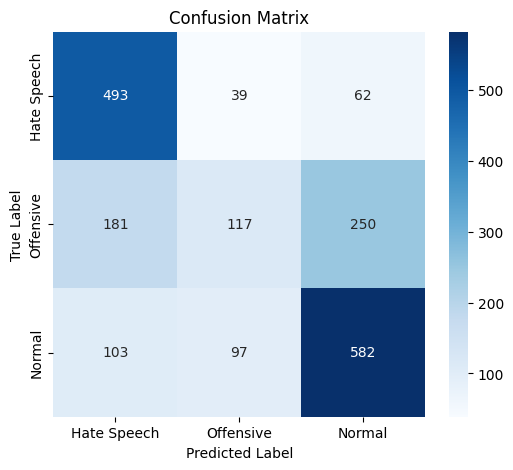

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=["hatespeech", "offensive", "normal"])

# Print Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, predicted_labels, target_names=["hatespeech", "offensive", "normal"]))

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Normal"],
            yticklabels=["Hate Speech", "Offensive", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
pass

messages = [                    # Change below!
    {"role": "user", "content": "Describe anything special about a sequence. Your input is 1, 1, 2, 3, 5, 8,"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

The sequence 1, 1, 2, 3, 5, 8 is a special sequence known as the Fibonacci sequence. The Fibonacci sequence is a series of numbers where each number is the sum of the two previous numbers, starting with 0 and 1. In this case, the sequence is 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, and so on. The Fibonacci sequence has many interesting properties and is widely studied in mathematics and computer science.<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")